In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from joblib import load

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed
set_random_seed(12)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaco

# Preprocessing

In [2]:
data = pd.read_csv('./datasets/IBM_daily.csv').sort_values(by='date')

In [3]:
data

,date,1. open,2. high,3. low,4. close,5. volume
5217,1999-11-01,98.50,98.8100,96.37,96.75,9551800.0
5216,1999-11-02,96.75,96.8100,93.69,94.81,11105400.0
5215,1999-11-03,95.87,95.9400,93.50,94.37,10369100.0
5214,1999-11-04,94.44,94.4400,90.00,91.56,16697600.0
5213,1999-11-05,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...,...
4,2020-07-22,125.90,129.4700,125.80,128.67,8195366.0
3,2020-07-23,129.10,129.3700,127.15,127.33,4220136.0
2,2020-07-24,126.48,127.6459,125.50,125.79,3531076.0
1,2020-07-27,124.86,126.3200,124.71,126.21,3733547.0


In [4]:
data = data.drop(columns='date')
data

,1. open,2. high,3. low,4. close,5. volume
5217,98.50,98.8100,96.37,96.75,9551800.0
5216,96.75,96.8100,93.69,94.81,11105400.0
5215,95.87,95.9400,93.50,94.37,10369100.0
5214,94.44,94.4400,90.00,91.56,16697600.0
5213,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...
4,125.90,129.4700,125.80,128.67,8195366.0
3,129.10,129.3700,127.15,127.33,4220136.0
2,126.48,127.6459,125.50,125.79,3531076.0
1,124.86,126.3200,124.71,126.21,3733547.0


In [5]:
# Sequence for the LSTM network
backlook = 92

# Days to predict
days = 5

# Size of data split for testing
train_size = 0.9

In [6]:
# Train-Test split
split = int(len(data) * train_size)

train = data.to_numpy()[:split]
test = data.to_numpy()[split:]

In [7]:
# Load normalisers
normaliser = load('./normalisers/x_normaliser.joblib')
y_normaliser = load('./normalisers/y_normaliser.joblib')

In [8]:
# Normalise data
train_norm = normaliser.transform(train)
test_norm = normaliser.transform(test)

##### Now I get indexes for chunks from 5 in 5 days

In [9]:
index = []

for i in range(days):
    index.append(np.arange(i,len(train),days))

In [10]:
ordered_index = []

for i in range(len(index[0]) - backlook):
    for e in range(days):
        try: ordered_index.append(index[e][i:i+backlook])
        except: pass

In [11]:
# Normalised train chunks
X_train = np.array([train_norm[ix].copy() for ix in ordered_index])
Y_train = np.array([train_norm[ordered_index[i+days][-1],0].copy() for i in range(len(ordered_index) - days)])
Y_train = np.expand_dims(Y_train, -1)

In [12]:
# Delete those sequences that doesn't have a -th day in the results
X_train = X_train[:Y_train.shape[0]]

##### Same for test

In [13]:
index = []

for i in range(days):
    index.append(np.arange(i,len(test),days))

In [14]:
ordered_index = []

for i in range(len(index[0]) - backlook):
    for e in range(days):
        try: ordered_index.append(index[e][i:i+backlook])
        except: pass

In [15]:
# Normalised train chunks
X_test = np.array([test_norm[ix].copy() for ix in ordered_index])
Y_test = np.array([test_norm[ordered_index[i+days][-1],0].copy() for i in range(len(ordered_index) - days)])
Y_test = np.expand_dims(Y_test, -1)

In [16]:
# Delete those sequences that doesn't have a -th day in the results
X_test = X_test[:Y_test.shape[0]]

# Model selection

##### Model constructor

In [17]:
def build_lstm(x, y, batch_size=512, epochs=24, **params):
    
    # List of parameters
    if 'lstmsize' not in params: params['lstmsize'] = x.shape[1]
    if 'density' not in params: params['density'] = int((params['lstmsize']//1.5)*2)
    if 'activation' not in params: params['activation'] = 'relu'
    if 'twice' not in params: params['twice'] = False
    if 'optimizer' not in params: params['optimizer'] = 'adam'
    if 'shuffle' not in params: params['shuffle'] = False
    
    # Model definition
    model = Sequential()
    
    model.add(LSTM(params['lstmsize'], input_shape=x.shape[1:], return_sequences=params['twice']))
    
    if 'dropout' in params:
        model.add(Dropout(params['dropout']))
    
    if params['twice']:
        model.add(LSTM(params['lstmsize']))
        
        if 'dropout' in params:
            model.add(Dropout(params['dropout']))
            
    model.add(Dense(params['density'], activation=params['activation']))
    
    if 'full_density' in params and params['full_density']:
        density = params['density']//2
        while density >= 12:
            model.add(Dense(density, activation=params['activation']))
            density //= 2
            
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse', optimizer=params['optimizer'])
    
    if 'callbacks' in params:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'],
                            callbacks=params['callbacks'])
    else:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'])
    
    return [model, callback, params]

##### Evolutive algorith to search for the most optimal model

In [18]:
def set_genes(x, y, population_size, population=[]):
    if population_size-len(population) < 0:
        print('population size must be greater or equal than actual population')
        return
    
    if len(population) > 0:
        if len(population) < 3:
            print('population should be empty or 3 at least')
            return
        
        population[2] = breed_genes(x, y, population[0][2].copy())
        population[1] = breed_genes(x, y, combine=(population[0][2], population[1][2]))
        population = population[:3]
    
    for _ in range(population_size-len(population)):
        subject = breed_genes(x, y)
        population.append(subject)
        
    return population

def breed_genes(x, y, genes={}, combine=None):
    genes['x'] = x
    genes['y'] = y
    
    if type(combine) is list or type(combine) is tuple:
        genes['lstmsize'] = combine[np.random.randint(0,2)]['lstmsize']
        genes['density'] = combine[np.random.randint(0,2)]['density']
        genes['activation'] = combine[np.random.randint(0,2)]['activation']
        genes['twice'] = combine[np.random.randint(0,2)]['twice']
        genes['optimizer'] = combine[np.random.randint(0,2)]['optimizer']
        genes['shuffle'] = combine[np.random.randint(0,2)]['shuffle']
        
        genes['dropout'] = combine[np.random.randint(0,2)].get('dropout')
        if genes['dropout'] is None: del genes['dropout']
        genes['full_density'] = combine[np.random.randint(0,2)].get('full_density')
        if genes['full_density'] is None: del genes['full_density']
            
    else:
        if np.random.randint(0,3) == 1:
            genes['lstmsize'] = int((np.random.randint(x.shape[1],x.shape[1]*2)//2)*2)

        if np.random.randint(0,3) == 1:
            genes['density'] = int((np.random.randint(x.shape[1]//2,x.shape[1]*2.66)//2)*2)

        if np.random.randint(0,3) == 1:
            activation = [
                'relu',
                'sigmoid',
                'softplus',
                'softsign',
                'tanh',
                'selu',
                'elu',
                'exponential'
            ]
            genes['activation'] = activation[np.random.randint(0,8)]

        if np.random.randint(0,3) == 1:
            genes['twice'] = True

        if np.random.randint(0,3) == 1:
            optimizer = [
                'sgd',
                'rmsprop',
                'adam',
                'adadelta',
                'adagrad',
                'adamax',
                'nadam'
            ]
            genes['optimizer'] = optimizer[np.random.randint(0,7)]

        if np.random.randint(0,3) == 1:
            genes['shuffle'] = True

        if np.random.randint(0,3) == 1:
            genes['dropout'] = np.random.randint(1,4)/10

        if np.random.randint(0,3) == 1:
            genes['full_density'] = True
            
    new_model = build_lstm(**genes)
        
    return new_model

In [19]:
def breed_population(x, y, generations, population_size, population=[]):
    
    if generations > 1 and population_size < 3:
        print('population size should be of a minimum of 3 for more than one generation')
        return
    
    for g in range(generations):
        print(f'\nGENERATION {g}\n')
        population = set_genes(x, y, population_size, population)
        population = sorted(population, key=lambda x: x[1].history['val_loss'][-1]+x[1].history['loss'][-1])
        
    return population

In [20]:
best_models = breed_population(X_train, Y_train, generations=20, population_size=10)


GENERATION 0

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 3s 707us/step - loss: 0.0173 - val_loss: 0.0257
Epoch 2/24
3811/3811 [==============================] - 2s 488us/step - loss: 0.0497 - val_loss: 0.0577
Epoch 3/24
3811/3811 [==============================] - 2s 482us/step - loss: 0.0416 - val_loss: 0.0028
Epoch 4/24
3811/3811 [==============================] - 2s 491us/step - loss: 0.0059 - val_loss: 0.0048
Epoch 5/24
3811/3811 [==============================] - 2s 496us/step - loss: 0.0060 - val_loss: 0.0135
Epoch 6/24
3811/3811 [==============================] - 2s 490us/step - loss: 0.0031 - val_loss: 0.0061
Epoch 7/24
3811/3811 [==============================] - 2s 490us/step - loss: 0.0054 - val_loss: 0.0131
Epoch 8/24
3811/3811 [==============================] - 2s 494us/step - loss: 0.0039 - val

3811/3811 [==============================] - 2s 493us/step - loss: 0.0124 - val_loss: 0.0033
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 3s 752us/step - loss: 0.1591 - val_loss: 0.0176
Epoch 2/24
3811/3811 [==============================] - 2s 538us/step - loss: 0.0127 - val_loss: 0.0082
Epoch 3/24
3811/3811 [==============================] - 2s 537us/step - loss: 0.0122 - val_loss: 0.0043
Epoch 4/24
3811/3811 [==============================] - 2s 532us/step - loss: 0.0095 - val_loss: 0.0028
Epoch 5/24
3811/3811 [==============================] - 2s 532us/step - loss: 0.0068 - val_loss: 0.0082
Epoch 6/24
3811/3811 [==============================] - 2s 534us/step - loss: 0.0138 - val_loss: 0.0954
Epoch 7/24
3811/3811 [==============================] - 2s 538us/step - loss: 0.0178 - val_loss: 0.0113
Epoch 8/24
3811/3811 [==============================] - 2s 541us/step - loss: 0.0162 - val_loss: 0.0133
Epoch 9/24
3811/3811 [======

3811/3811 [==============================] - 2s 554us/step - loss: 0.0146 - val_loss: 0.0101
Epoch 5/24
3811/3811 [==============================] - 2s 560us/step - loss: 0.0116 - val_loss: 0.0271
Epoch 6/24
3811/3811 [==============================] - 2s 554us/step - loss: 0.0095 - val_loss: 0.0106
Epoch 7/24
3811/3811 [==============================] - 2s 561us/step - loss: 0.0056 - val_loss: 0.0067
Epoch 8/24
3811/3811 [==============================] - 2s 558us/step - loss: 0.0043 - val_loss: 0.0040
Epoch 9/24
3811/3811 [==============================] - 2s 562us/step - loss: 0.0036 - val_loss: 0.0031
Epoch 10/24
3811/3811 [==============================] - 2s 558us/step - loss: 0.0032 - val_loss: 0.0027
Epoch 11/24
3811/3811 [==============================] - 2s 557us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 12/24
3811/3811 [==============================] - 2s 558us/step - loss: 0.0029 - val_loss: 0.0030
Epoch 13/24
3811/3811 [==============================] - 2s 557us/step -

3811/3811 [==============================] - 2s 574us/step - loss: 0.0032 - val_loss: 0.0030
Epoch 10/24
3811/3811 [==============================] - 2s 561us/step - loss: 0.0031 - val_loss: 0.0032
Epoch 11/24
3811/3811 [==============================] - 2s 556us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 12/24
3811/3811 [==============================] - 2s 562us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 13/24
3811/3811 [==============================] - 2s 560us/step - loss: 0.0026 - val_loss: 0.0024
Epoch 14/24
3811/3811 [==============================] - 2s 559us/step - loss: 0.0026 - val_loss: 0.0026
Epoch 15/24
3811/3811 [==============================] - 2s 560us/step - loss: 0.0025 - val_loss: 0.0024
Epoch 16/24
3811/3811 [==============================] - 2s 562us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 17/24
3811/3811 [==============================] - 2s 562us/step - loss: 0.0025 - val_loss: 0.0021
Epoch 18/24
3811/3811 [==============================] - 2s 557us/s

Epoch 14/24
3811/3811 [==============================] - 2s 494us/step - loss: 0.0035 - val_loss: 0.0031
Epoch 15/24
3811/3811 [==============================] - 2s 498us/step - loss: 0.0032 - val_loss: 0.0035
Epoch 16/24
3811/3811 [==============================] - 2s 495us/step - loss: 0.0032 - val_loss: 0.0034
Epoch 17/24
3811/3811 [==============================] - 2s 501us/step - loss: 0.0032 - val_loss: 0.0028
Epoch 18/24
3811/3811 [==============================] - 2s 495us/step - loss: 0.0030 - val_loss: 0.0037
Epoch 19/24
3811/3811 [==============================] - 2s 496us/step - loss: 0.0031 - val_loss: 0.0026
Epoch 20/24
3811/3811 [==============================] - 2s 507us/step - loss: 0.0030 - val_loss: 0.0025
Epoch 21/24
3811/3811 [==============================] - 2s 497us/step - loss: 0.0029 - val_loss: 0.0028
Epoch 22/24
3811/3811 [==============================] - 2s 501us/step - loss: 0.0028 - val_loss: 0.0025
Epoch 23/24
3811/3811 [==============================] 

Epoch 19/24
3811/3811 [==============================] - 1s 384us/step - loss: 0.0019 - val_loss: 0.0021
Epoch 20/24
3811/3811 [==============================] - 1s 387us/step - loss: 0.0019 - val_loss: 0.0021
Epoch 21/24
3811/3811 [==============================] - 1s 381us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 22/24
3811/3811 [==============================] - 1s 383us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 23/24
3811/3811 [==============================] - 1s 385us/step - loss: 0.0018 - val_loss: 0.0021
Epoch 24/24
3811/3811 [==============================] - 1s 389us/step - loss: 0.0018 - val_loss: 0.0020
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 3s 881us/step - loss: 0.1155 - val_loss: 0.0280
Epoch 2/24
3811/3811 [==============================] - 1s 387us/step - loss: 0.0220 - val_loss: 0.0145
Epoch 3/24
3811/3811 [==============================] - 1s 381us/step - loss: 0.0081 - val_loss: 0.0071
Epoch 4/24


Epoch 24/24
3811/3811 [==============================] - 2s 577us/step - loss: 0.0021 - val_loss: 0.0026

GENERATION 2

Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 4s 942us/step - loss: 0.0962 - val_loss: 0.1018
Epoch 2/24
3811/3811 [==============================] - 1s 385us/step - loss: 0.0420 - val_loss: 0.0140
Epoch 3/24
3811/3811 [==============================] - 1s 388us/step - loss: 0.0142 - val_loss: 0.0046
Epoch 4/24
3811/3811 [==============================] - 1s 385us/step - loss: 0.0078 - val_loss: 0.0098
Epoch 5/24
3811/3811 [==============================] - 1s 389us/step - loss: 0.0056 - val_loss: 0.0106
Epoch 6/24
3811/3811 [==============================] - 1s 383us/step - loss: 0.0049 - val_loss: 0.0087
Epoch 7/24
3811/3811 [==============================] - 2s 396us/step - loss: 0.0043 - val_loss: 0.0053
Epoch 8/24
3811/3811 [==============================] - 1s 384us/step - loss: 0.0038 - val_loss: 0.0044
E

3811/3811 [==============================] - 2s 559us/step - loss: 0.0046 - val_loss: 0.0028
Epoch 5/24
3811/3811 [==============================] - 2s 560us/step - loss: 0.0035 - val_loss: 0.0057
Epoch 6/24
3811/3811 [==============================] - 2s 561us/step - loss: 0.0030 - val_loss: 0.0022
Epoch 7/24
3811/3811 [==============================] - 2s 561us/step - loss: 0.0027 - val_loss: 0.0030
Epoch 8/24
3811/3811 [==============================] - 2s 560us/step - loss: 0.0026 - val_loss: 0.0025
Epoch 9/24
3811/3811 [==============================] - 2s 565us/step - loss: 0.0025 - val_loss: 0.0024
Epoch 10/24
3811/3811 [==============================] - 2s 557us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 11/24
3811/3811 [==============================] - 2s 560us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 12/24
3811/3811 [==============================] - 2s 558us/step - loss: 0.0023 - val_loss: 0.0026
Epoch 13/24
3811/3811 [==============================] - 2s 559us/step -

3811/3811 [==============================] - 2s 403us/step - loss: 0.0034 - val_loss: 0.0029
Epoch 10/24
3811/3811 [==============================] - 2s 403us/step - loss: 0.0032 - val_loss: 0.0029
Epoch 11/24
3811/3811 [==============================] - 2s 404us/step - loss: 0.0032 - val_loss: 0.0029
Epoch 12/24
3811/3811 [==============================] - 2s 400us/step - loss: 0.0032 - val_loss: 0.0025
Epoch 13/24
3811/3811 [==============================] - 2s 406us/step - loss: 0.0030 - val_loss: 0.0024
Epoch 14/24
3811/3811 [==============================] - 2s 399us/step - loss: 0.0029 - val_loss: 0.0027
Epoch 15/24
3811/3811 [==============================] - 2s 403us/step - loss: 0.0029 - val_loss: 0.0031
Epoch 16/24
3811/3811 [==============================] - 2s 405us/step - loss: 0.0028 - val_loss: 0.0025
Epoch 17/24
3811/3811 [==============================] - 2s 400us/step - loss: 0.0027 - val_loss: 0.0018
Epoch 18/24
3811/3811 [==============================] - 2s 409us/s

Epoch 14/24
3811/3811 [==============================] - 1s 375us/step - loss: 0.0071 - val_loss: 0.0050
Epoch 15/24
3811/3811 [==============================] - 1s 377us/step - loss: 0.0043 - val_loss: 0.0029
Epoch 16/24
3811/3811 [==============================] - 1s 376us/step - loss: 0.0030 - val_loss: 0.0020
Epoch 17/24
3811/3811 [==============================] - 1s 382us/step - loss: 0.0035 - val_loss: 0.0044
Epoch 18/24
3811/3811 [==============================] - 1s 374us/step - loss: 0.0038 - val_loss: 0.0027
Epoch 19/24
3811/3811 [==============================] - 1s 378us/step - loss: 0.0032 - val_loss: 0.0039
Epoch 20/24
3811/3811 [==============================] - 1s 374us/step - loss: 0.0050 - val_loss: 0.0034
Epoch 21/24
3811/3811 [==============================] - 1s 374us/step - loss: 0.0033 - val_loss: 0.0045
Epoch 22/24
3811/3811 [==============================] - 1s 383us/step - loss: 0.0030 - val_loss: 0.0014
Epoch 23/24
3811/3811 [==============================] 

Epoch 19/24
3811/3811 [==============================] - 2s 575us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 20/24
3811/3811 [==============================] - 2s 574us/step - loss: 0.0015 - val_loss: 0.0023
Epoch 21/24
3811/3811 [==============================] - 2s 576us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 22/24
3811/3811 [==============================] - 2s 572us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 23/24
3811/3811 [==============================] - 2s 574us/step - loss: 0.0015 - val_loss: 0.0023
Epoch 24/24
3811/3811 [==============================] - 2s 570us/step - loss: 0.0015 - val_loss: 0.0014
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 6s 1ms/step - loss: 0.0607 - val_loss: 0.0211
Epoch 2/24
3811/3811 [==============================] - 2s 570us/step - loss: 0.0118 - val_loss: 0.0025
Epoch 3/24
3811/3811 [==============================] - 2s 569us/step - loss: 0.0069 - val_loss: 0.0091
Epoch 4/24
38

Epoch 24/24
3811/3811 [==============================] - 2s 470us/step - loss: 0.0017 - val_loss: 0.0015
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 5s 1ms/step - loss: nan - val_loss: nan
Epoch 2/24
3811/3811 [==============================] - 2s 472us/step - loss: nan - val_loss: nan
Epoch 3/24
3811/3811 [==============================] - 2s 470us/step - loss: nan - val_loss: nan
Epoch 4/24
3811/3811 [==============================] - 2s 472us/step - loss: nan - val_loss: nan
Epoch 5/24
3811/3811 [==============================] - 2s 471us/step - loss: nan - val_loss: nan
Epoch 6/24
3811/3811 [==============================] - 2s 471us/step - loss: nan - val_loss: nan
Epoch 7/24
3811/3811 [==============================] - 2s 483us/step - loss: nan - val_loss: nan
Epoch 8/24
3811/3811 [==============================] - 2s 473us/step - loss: nan - val_loss: nan
Epoch 9/24
3811/3811 [==============================] - 2s 469us/s

Epoch 6/24
3811/3811 [==============================] - 2s 573us/step - loss: 0.0027 - val_loss: 0.0022
Epoch 7/24
3811/3811 [==============================] - 2s 577us/step - loss: 0.0023 - val_loss: 0.0021
Epoch 8/24
3811/3811 [==============================] - 2s 571us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 9/24
3811/3811 [==============================] - 2s 574us/step - loss: 0.0019 - val_loss: 0.0019
Epoch 10/24
3811/3811 [==============================] - 2s 573us/step - loss: 0.0019 - val_loss: 0.0024
Epoch 11/24
3811/3811 [==============================] - 2s 570us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 12/24
3811/3811 [==============================] - 2s 580us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 13/24
3811/3811 [==============================] - 2s 574us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 14/24
3811/3811 [==============================] - 2s 578us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 15/24
3811/3811 [==============================] - 2s

3811/3811 [==============================] - 2s 472us/step - loss: 0.0026 - val_loss: 0.0028
Epoch 12/24
3811/3811 [==============================] - 2s 472us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 13/24
3811/3811 [==============================] - 2s 474us/step - loss: 0.0036 - val_loss: 0.0023
Epoch 14/24
3811/3811 [==============================] - 2s 475us/step - loss: 0.0026 - val_loss: 0.0024
Epoch 15/24
3811/3811 [==============================] - 2s 474us/step - loss: 0.0025 - val_loss: 0.0026
Epoch 16/24
3811/3811 [==============================] - 2s 474us/step - loss: 0.0026 - val_loss: 0.0025
Epoch 17/24
3811/3811 [==============================] - 2s 471us/step - loss: 0.0037 - val_loss: 0.0022
Epoch 18/24
3811/3811 [==============================] - 2s 473us/step - loss: 0.0025 - val_loss: 0.0030
Epoch 19/24
3811/3811 [==============================] - 2s 472us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 20/24
3811/3811 [==============================] - 2s 469us/s

3811/3811 [==============================] - 2s 474us/step - loss: 0.0091 - val_loss: 0.0116
Epoch 17/24
3811/3811 [==============================] - 2s 469us/step - loss: 0.0073 - val_loss: 0.0138
Epoch 18/24
3811/3811 [==============================] - 2s 476us/step - loss: 0.0098 - val_loss: 0.0223
Epoch 19/24
3811/3811 [==============================] - 2s 475us/step - loss: 0.0106 - val_loss: 0.0138
Epoch 20/24
3811/3811 [==============================] - 2s 480us/step - loss: 0.0082 - val_loss: 0.0169
Epoch 21/24
3811/3811 [==============================] - 2s 480us/step - loss: 0.0087 - val_loss: 0.0223
Epoch 22/24
3811/3811 [==============================] - 2s 473us/step - loss: 0.0113 - val_loss: 0.0125
Epoch 23/24
3811/3811 [==============================] - 2s 473us/step - loss: 0.0058 - val_loss: 0.0095
Epoch 24/24
3811/3811 [==============================] - 2s 474us/step - loss: 0.0063 - val_loss: 0.0132
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811

Epoch 21/24
3811/3811 [==============================] - 2s 571us/step - loss: 0.0015 - val_loss: 0.0020
Epoch 22/24
3811/3811 [==============================] - 2s 578us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 23/24
3811/3811 [==============================] - 2s 575us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 24/24
3811/3811 [==============================] - 2s 578us/step - loss: 0.0015 - val_loss: 0.0019
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 8s 2ms/step - loss: 4.4569 - val_loss: 0.5876
Epoch 2/24
3811/3811 [==============================] - 2s 575us/step - loss: 0.1741 - val_loss: 0.0132
Epoch 3/24
3811/3811 [==============================] - 2s 577us/step - loss: 0.0933 - val_loss: 0.0980
Epoch 4/24
3811/3811 [==============================] - 2s 573us/step - loss: 0.0837 - val_loss: 0.0346
Epoch 5/24
3811/3811 [==============================] - 2s 578us/step - loss: 0.0728 - val_loss: 0.0180
Epoch 6/24
3811

3811/3811 [==============================] - 8s 2ms/step - loss: 0.1708 - val_loss: 0.0065
Epoch 2/24
3811/3811 [==============================] - 2s 557us/step - loss: 0.0605 - val_loss: 0.0081
Epoch 3/24
3811/3811 [==============================] - 2s 565us/step - loss: 0.0231 - val_loss: 0.0051
Epoch 4/24
3811/3811 [==============================] - 2s 560us/step - loss: 0.0091 - val_loss: 0.0043
Epoch 5/24
3811/3811 [==============================] - 2s 564us/step - loss: 0.0064 - val_loss: 0.0048
Epoch 6/24
3811/3811 [==============================] - 2s 561us/step - loss: 0.0055 - val_loss: 0.0103
Epoch 7/24
3811/3811 [==============================] - 2s 564us/step - loss: 0.0047 - val_loss: 0.0054
Epoch 8/24
3811/3811 [==============================] - 2s 567us/step - loss: 0.0041 - val_loss: 0.0039
Epoch 9/24
3811/3811 [==============================] - 2s 555us/step - loss: 0.0040 - val_loss: 0.0046
Epoch 10/24
3811/3811 [==============================] - 2s 566us/step - loss

3811/3811 [==============================] - 2s 558us/step - loss: nan - val_loss: nan
Epoch 5/24
3811/3811 [==============================] - 2s 556us/step - loss: nan - val_loss: nan
Epoch 6/24
3811/3811 [==============================] - 2s 558us/step - loss: nan - val_loss: nan
Epoch 7/24
3811/3811 [==============================] - 2s 555us/step - loss: nan - val_loss: nan
Epoch 8/24
3811/3811 [==============================] - 2s 563us/step - loss: nan - val_loss: nan
Epoch 9/24
3811/3811 [==============================] - 2s 553us/step - loss: nan - val_loss: nan
Epoch 10/24
3811/3811 [==============================] - 2s 556us/step - loss: nan - val_loss: nan
Epoch 11/24
3811/3811 [==============================] - 2s 561us/step - loss: nan - val_loss: nan
Epoch 12/24
3811/3811 [==============================] - 2s 558us/step - loss: nan - val_loss: nan
Epoch 13/24
3811/3811 [==============================] - 2s 555us/step - loss: nan - val_loss: nan
Epoch 14/24
3811/3811 [====

3811/3811 [==============================] - 2s 574us/step - loss: 0.0018 - val_loss: 0.0023
Epoch 11/24
3811/3811 [==============================] - 2s 567us/step - loss: 0.0017 - val_loss: 0.0023
Epoch 12/24
3811/3811 [==============================] - 2s 576us/step - loss: 0.0017 - val_loss: 0.0023
Epoch 13/24
3811/3811 [==============================] - 2s 573us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 14/24
3811/3811 [==============================] - 2s 568us/step - loss: 0.0017 - val_loss: 0.0025
Epoch 15/24
3811/3811 [==============================] - 2s 577us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 16/24
3811/3811 [==============================] - 2s 574us/step - loss: 0.0016 - val_loss: 0.0026
Epoch 17/24
3811/3811 [==============================] - 2s 572us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 18/24
3811/3811 [==============================] - 2s 570us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 19/24
3811/3811 [==============================] - 2s 568us/s

3811/3811 [==============================] - 1s 373us/step - loss: 0.0028 - val_loss: 0.0027
Epoch 16/24
3811/3811 [==============================] - 1s 366us/step - loss: 0.0028 - val_loss: 0.0023
Epoch 17/24
3811/3811 [==============================] - 1s 371us/step - loss: 0.0027 - val_loss: 0.0023
Epoch 18/24
3811/3811 [==============================] - 1s 371us/step - loss: 0.0027 - val_loss: 0.0021
Epoch 19/24
3811/3811 [==============================] - 1s 371us/step - loss: 0.0026 - val_loss: 0.0020
Epoch 20/24
3811/3811 [==============================] - 1s 371us/step - loss: 0.0025 - val_loss: 0.0020
Epoch 21/24
3811/3811 [==============================] - 1s 377us/step - loss: 0.0025 - val_loss: 0.0024
Epoch 22/24
3811/3811 [==============================] - 1s 371us/step - loss: 0.0025 - val_loss: 0.0018
Epoch 23/24
3811/3811 [==============================] - 1s 370us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 24/24
3811/3811 [==============================] - 1s 369us/s

3811/3811 [==============================] - 1s 375us/step - loss: 0.0061 - val_loss: 0.0040
Epoch 21/24
3811/3811 [==============================] - 1s 368us/step - loss: 0.0037 - val_loss: 0.0018
Epoch 22/24
3811/3811 [==============================] - 1s 373us/step - loss: 0.0027 - val_loss: 0.0016
Epoch 23/24
3811/3811 [==============================] - 1s 374us/step - loss: 0.0027 - val_loss: 0.0016
Epoch 24/24
3811/3811 [==============================] - 1s 374us/step - loss: 0.0024 - val_loss: 0.0035

GENERATION 7

Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 10s 3ms/step - loss: 0.6171 - val_loss: 0.0074
Epoch 2/24
3811/3811 [==============================] - 2s 564us/step - loss: 0.0502 - val_loss: 0.0204
Epoch 3/24
3811/3811 [==============================] - 2s 558us/step - loss: 0.0230 - val_loss: 0.0244
Epoch 4/24
3811/3811 [==============================] - 2s 565us/step - loss: 0.0120 - val_loss: 0.0027
Epoch 5/24

Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 11s 3ms/step - loss: 0.0646 - val_loss: 0.0269
Epoch 2/24
3811/3811 [==============================] - 2s 508us/step - loss: 0.0132 - val_loss: 0.0030
Epoch 3/24
3811/3811 [==============================] - 2s 511us/step - loss: 0.0067 - val_loss: 0.0120
Epoch 4/24
3811/3811 [==============================] - 2s 512us/step - loss: 0.0049 - val_loss: 0.0027
Epoch 5/24
3811/3811 [==============================] - 2s 514us/step - loss: 0.0037 - val_loss: 0.0024
Epoch 6/24
3811/3811 [==============================] - 2s 511us/step - loss: 0.0031 - val_loss: 0.0041
Epoch 7/24
3811/3811 [==============================] - 2s 511us/step - loss: 0.0027 - val_loss: 0.0033
Epoch 8/24
3811/3811 [==============================] - 2s 510us/step - loss: 0.0023 - val_loss: 0.0028
Epoch 9/24
3811/3811 [==============================] - 2s 510us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 10/24
3811/3

3811/3811 [==============================] - 2s 513us/step - loss: 0.0112 - val_loss: 0.0139
Epoch 6/24
3811/3811 [==============================] - 2s 515us/step - loss: 0.0091 - val_loss: 0.0143
Epoch 7/24
3811/3811 [==============================] - 2s 510us/step - loss: 0.0086 - val_loss: 0.0149
Epoch 8/24
3811/3811 [==============================] - 2s 509us/step - loss: 0.0099 - val_loss: 0.0122
Epoch 9/24
3811/3811 [==============================] - 2s 518us/step - loss: 0.0086 - val_loss: 0.0088
Epoch 10/24
3811/3811 [==============================] - 2s 520us/step - loss: 0.0056 - val_loss: 0.0081
Epoch 11/24
3811/3811 [==============================] - 2s 513us/step - loss: 0.0064 - val_loss: 0.0153
Epoch 12/24
3811/3811 [==============================] - 2s 511us/step - loss: 0.0105 - val_loss: 0.0123
Epoch 13/24
3811/3811 [==============================] - 2s 509us/step - loss: 0.0079 - val_loss: 0.0136
Epoch 14/24
3811/3811 [==============================] - 2s 514us/step 

Epoch 10/24
3811/3811 [==============================] - 2s 586us/step - loss: 0.0019 - val_loss: 0.0029
Epoch 11/24
3811/3811 [==============================] - 2s 595us/step - loss: 0.0018 - val_loss: 0.0023
Epoch 12/24
3811/3811 [==============================] - 2s 584us/step - loss: 0.0018 - val_loss: 0.0019
Epoch 13/24
3811/3811 [==============================] - 2s 586us/step - loss: 0.0017 - val_loss: 0.0023
Epoch 14/24
3811/3811 [==============================] - 2s 584us/step - loss: 0.0017 - val_loss: 0.0022
Epoch 15/24
3811/3811 [==============================] - 2s 588us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 16/24
3811/3811 [==============================] - 2s 589us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 17/24
3811/3811 [==============================] - 2s 588us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 18/24
3811/3811 [==============================] - 2s 587us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 19/24
3811/3811 [==============================] 

Epoch 15/24
3811/3811 [==============================] - 2s 582us/step - loss: 0.0022 - val_loss: 0.0062
Epoch 16/24
3811/3811 [==============================] - 2s 586us/step - loss: 0.0072 - val_loss: 0.0032
Epoch 17/24
3811/3811 [==============================] - 2s 585us/step - loss: 0.0028 - val_loss: 0.0020
Epoch 18/24
3811/3811 [==============================] - 2s 581us/step - loss: 0.0017 - val_loss: 0.0036
Epoch 19/24
3811/3811 [==============================] - 2s 578us/step - loss: 0.0039 - val_loss: 0.0069
Epoch 20/24
3811/3811 [==============================] - 2s 586us/step - loss: 0.0026 - val_loss: 0.0041
Epoch 21/24
3811/3811 [==============================] - 2s 581us/step - loss: 0.0021 - val_loss: 0.0072
Epoch 22/24
3811/3811 [==============================] - 2s 583us/step - loss: 0.0028 - val_loss: 0.0055
Epoch 23/24
3811/3811 [==============================] - 2s 586us/step - loss: 0.0024 - val_loss: 0.0052
Epoch 24/24
3811/3811 [==============================] 

Epoch 20/24
3811/3811 [==============================] - 2s 548us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 21/24
3811/3811 [==============================] - 2s 547us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 22/24
3811/3811 [==============================] - 2s 556us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 23/24
3811/3811 [==============================] - 2s 545us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 24/24
3811/3811 [==============================] - 2s 549us/step - loss: 0.0016 - val_loss: 0.0018
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 14s 4ms/step - loss: 0.0744 - val_loss: 0.0202
Epoch 2/24
3811/3811 [==============================] - 2s 562us/step - loss: 0.0121 - val_loss: 0.0048
Epoch 3/24
3811/3811 [==============================] - 2s 551us/step - loss: 0.0071 - val_loss: 0.0067
Epoch 4/24
3811/3811 [==============================] - 2s 555us/step - loss: 0.0048 - val_loss: 0.0066
Epoch 5/24
38

Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 15s 4ms/step - loss: 0.0421 - val_loss: 0.0027
Epoch 2/24
3811/3811 [==============================] - 2s 585us/step - loss: 0.0095 - val_loss: 0.0024
Epoch 3/24
3811/3811 [==============================] - 2s 586us/step - loss: 0.0059 - val_loss: 0.0023
Epoch 4/24
3811/3811 [==============================] - 2s 584us/step - loss: 0.0045 - val_loss: 0.0042
Epoch 5/24
3811/3811 [==============================] - 2s 583us/step - loss: 0.0033 - val_loss: 0.0065
Epoch 6/24
3811/3811 [==============================] - 2s 581us/step - loss: 0.0028 - val_loss: 0.0033
Epoch 7/24
3811/3811 [==============================] - 2s 592us/step - loss: 0.0022 - val_loss: 0.0036
Epoch 8/24
3811/3811 [==============================] - 2s 585us/step - loss: 0.0021 - val_loss: 0.0037
Epoch 9/24
3811/3811 [==============================] - 2s 582us/step - loss: 0.0020 - val_loss: 0.0024
Epoch 10/24
3811/3

Epoch 6/24
3811/3811 [==============================] - 2s 544us/step - loss: nan - val_loss: nan
Epoch 7/24
3811/3811 [==============================] - 2s 533us/step - loss: nan - val_loss: nan
Epoch 8/24
3811/3811 [==============================] - 2s 537us/step - loss: nan - val_loss: nan
Epoch 9/24
3811/3811 [==============================] - 2s 531us/step - loss: nan - val_loss: nan
Epoch 10/24
3811/3811 [==============================] - 2s 537us/step - loss: nan - val_loss: nan
Epoch 11/24
3811/3811 [==============================] - 2s 543us/step - loss: nan - val_loss: nan
Epoch 12/24
3811/3811 [==============================] - 2s 536us/step - loss: nan - val_loss: nan
Epoch 13/24
3811/3811 [==============================] - 2s 536us/step - loss: nan - val_loss: nan
Epoch 14/24
3811/3811 [==============================] - 2s 533us/step - loss: nan - val_loss: nan
Epoch 15/24
3811/3811 [==============================] - 2s 534us/step - loss: nan - val_loss: nan
Epoch 16/24
38

3811/3811 [==============================] - 1s 356us/step - loss: 0.0035 - val_loss: 0.0030
Epoch 14/24
3811/3811 [==============================] - 1s 348us/step - loss: 0.0033 - val_loss: 0.0037
Epoch 15/24
3811/3811 [==============================] - 1s 348us/step - loss: 0.0035 - val_loss: 0.0025
Epoch 16/24
3811/3811 [==============================] - 1s 351us/step - loss: 0.0035 - val_loss: 0.0024
Epoch 17/24
3811/3811 [==============================] - 1s 348us/step - loss: 0.0033 - val_loss: 0.0028
Epoch 18/24
3811/3811 [==============================] - 1s 347us/step - loss: 0.0031 - val_loss: 0.0026
Epoch 19/24
3811/3811 [==============================] - 1s 351us/step - loss: 0.0029 - val_loss: 0.0023
Epoch 20/24
3811/3811 [==============================] - 1s 348us/step - loss: 0.0031 - val_loss: 0.0032
Epoch 21/24
3811/3811 [==============================] - 1s 349us/step - loss: 0.0028 - val_loss: 0.0025
Epoch 22/24
3811/3811 [==============================] - 1s 355us/s

Epoch 18/24
3811/3811 [==============================] - 2s 588us/step - loss: 0.0017 - val_loss: 0.0017
Epoch 19/24
3811/3811 [==============================] - 2s 584us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 20/24
3811/3811 [==============================] - 2s 586us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 21/24
3811/3811 [==============================] - 2s 589us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 22/24
3811/3811 [==============================] - 2s 586us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 23/24
3811/3811 [==============================] - 2s 583us/step - loss: 0.0015 - val_loss: 0.0018
Epoch 24/24
3811/3811 [==============================] - 2s 582us/step - loss: 0.0015 - val_loss: 0.0014
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 17s 5ms/step - loss: 0.0643 - val_loss: 0.0052
Epoch 2/24
3811/3811 [==============================] - 2s 525us/step - loss: 0.0094 - val_loss: 0.0027
Epoch 3/24


Epoch 23/24
3811/3811 [==============================] - 2s 541us/step - loss: 0.0027 - val_loss: 0.0044
Epoch 24/24
3811/3811 [==============================] - 2s 534us/step - loss: 0.0026 - val_loss: 0.0073
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 18s 5ms/step - loss: 0.0524 - val_loss: 0.0027
Epoch 2/24
3811/3811 [==============================] - 2s 541us/step - loss: 0.0065 - val_loss: 0.0023
Epoch 3/24
3811/3811 [==============================] - 2s 533us/step - loss: 0.0048 - val_loss: 0.0021
Epoch 4/24
3811/3811 [==============================] - 2s 533us/step - loss: 0.0035 - val_loss: 0.0024
Epoch 5/24
3811/3811 [==============================] - 2s 531us/step - loss: 0.0030 - val_loss: 0.0024
Epoch 6/24
3811/3811 [==============================] - 2s 538us/step - loss: 0.0025 - val_loss: 0.0023
Epoch 7/24
3811/3811 [==============================] - 2s 536us/step - loss: 0.0023 - val_loss: 0.0028
Epoch 8/24
3811/

3811/3811 [==============================] - 1s 375us/step - loss: 0.1535 - val_loss: 0.1160
Epoch 4/24
3811/3811 [==============================] - 1s 374us/step - loss: 0.0725 - val_loss: 0.0091
Epoch 5/24
3811/3811 [==============================] - 1s 376us/step - loss: 0.0767 - val_loss: 0.0109
Epoch 6/24
3811/3811 [==============================] - 1s 377us/step - loss: 0.0638 - val_loss: 0.0379
Epoch 7/24
3811/3811 [==============================] - 1s 373us/step - loss: 0.0563 - val_loss: 0.0262
Epoch 8/24
3811/3811 [==============================] - 1s 379us/step - loss: 0.0410 - val_loss: 0.0041
Epoch 9/24
3811/3811 [==============================] - 1s 377us/step - loss: 0.0235 - val_loss: 0.0045
Epoch 10/24
3811/3811 [==============================] - 1s 376us/step - loss: 0.0102 - val_loss: 0.0097
Epoch 11/24
3811/3811 [==============================] - 1s 376us/step - loss: 0.0080 - val_loss: 0.0084
Epoch 12/24
3811/3811 [==============================] - 1s 373us/step - 

Epoch 8/24
3811/3811 [==============================] - 2s 584us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 9/24
3811/3811 [==============================] - 2s 582us/step - loss: 0.0020 - val_loss: 0.0027
Epoch 10/24
3811/3811 [==============================] - 2s 583us/step - loss: 0.0020 - val_loss: 0.0030
Epoch 11/24
3811/3811 [==============================] - 2s 579us/step - loss: 0.0019 - val_loss: 0.0020
Epoch 12/24
3811/3811 [==============================] - 2s 581us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 13/24
3811/3811 [==============================] - 2s 583us/step - loss: 0.0018 - val_loss: 0.0022
Epoch 14/24
3811/3811 [==============================] - 2s 586us/step - loss: 0.0017 - val_loss: 0.0022
Epoch 15/24
3811/3811 [==============================] - 2s 582us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 16/24
3811/3811 [==============================] - 2s 581us/step - loss: 0.0016 - val_loss: 0.0021
Epoch 17/24
3811/3811 [==============================] - 

3811/3811 [==============================] - 2s 585us/step - loss: 0.0102 - val_loss: 0.0076
Epoch 15/24
3811/3811 [==============================] - 2s 584us/step - loss: 0.0064 - val_loss: 0.0098
Epoch 16/24
3811/3811 [==============================] - 2s 585us/step - loss: 0.0112 - val_loss: 0.0040
Epoch 17/24
3811/3811 [==============================] - 2s 584us/step - loss: 0.0054 - val_loss: 0.0075
Epoch 18/24
3811/3811 [==============================] - 2s 578us/step - loss: 0.0102 - val_loss: 0.0023
Epoch 19/24
3811/3811 [==============================] - 2s 577us/step - loss: 0.0054 - val_loss: 0.0098
Epoch 20/24
3811/3811 [==============================] - 2s 584us/step - loss: 0.0085 - val_loss: 0.0035
Epoch 21/24
3811/3811 [==============================] - 2s 578us/step - loss: 0.0053 - val_loss: 0.0133
Epoch 22/24
3811/3811 [==============================] - 2s 583us/step - loss: 0.0082 - val_loss: 0.0042
Epoch 23/24
3811/3811 [==============================] - 2s 589us/s

3811/3811 [==============================] - 2s 400us/step - loss: 0.0039 - val_loss: 0.0266
Epoch 20/24
3811/3811 [==============================] - 2s 404us/step - loss: 0.0071 - val_loss: 0.0073
Epoch 21/24
3811/3811 [==============================] - 2s 396us/step - loss: 0.0044 - val_loss: 0.0273
Epoch 22/24
3811/3811 [==============================] - 2s 398us/step - loss: 0.0065 - val_loss: 0.0053
Epoch 23/24
3811/3811 [==============================] - 2s 399us/step - loss: 0.0048 - val_loss: 0.0368
Epoch 24/24
3811/3811 [==============================] - 2s 401us/step - loss: 0.0049 - val_loss: 0.0095

GENERATION 12

Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 22s 6ms/step - loss: 0.1001 - val_loss: 0.0038
Epoch 2/24
3811/3811 [==============================] - 2s 587us/step - loss: 0.0078 - val_loss: 0.0256
Epoch 3/24
3811/3811 [==============================] - 2s 580us/step - loss: 0.0173 - val_loss: 0.0034
Epoch 4/

Epoch 24/24
3811/3811 [==============================] - 2s 512us/step - loss: 0.0020 - val_loss: 0.0017
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 23s 6ms/step - loss: 0.0443 - val_loss: 0.0042
Epoch 2/24
3811/3811 [==============================] - 2s 394us/step - loss: 0.0186 - val_loss: 0.0026
Epoch 3/24
3811/3811 [==============================] - 1s 392us/step - loss: 0.0063 - val_loss: 0.0067
Epoch 4/24
3811/3811 [==============================] - 2s 404us/step - loss: 0.0048 - val_loss: 0.0033
Epoch 5/24
3811/3811 [==============================] - 1s 394us/step - loss: 0.0102 - val_loss: 0.0081
Epoch 6/24
3811/3811 [==============================] - 2s 397us/step - loss: 0.0064 - val_loss: 0.0027
Epoch 7/24
3811/3811 [==============================] - 2s 394us/step - loss: 0.0041 - val_loss: 0.0022
Epoch 8/24
3811/3811 [==============================] - 2s 396us/step - loss: 0.0094 - val_loss: 0.0032
Epoch 9/24
3811/3

3811/3811 [==============================] - 2s 518us/step - loss: 0.0062 - val_loss: 0.0086
Epoch 5/24
3811/3811 [==============================] - 2s 529us/step - loss: 0.0048 - val_loss: 0.0039
Epoch 6/24
3811/3811 [==============================] - 2s 520us/step - loss: 0.0040 - val_loss: 0.0039
Epoch 7/24
3811/3811 [==============================] - 2s 520us/step - loss: 0.0034 - val_loss: 0.0052
Epoch 8/24
3811/3811 [==============================] - 2s 519us/step - loss: 0.0030 - val_loss: 0.0044
Epoch 9/24
3811/3811 [==============================] - 2s 521us/step - loss: 0.0029 - val_loss: 0.0031
Epoch 10/24
3811/3811 [==============================] - 2s 519us/step - loss: 0.0027 - val_loss: 0.0029
Epoch 11/24
3811/3811 [==============================] - 2s 522us/step - loss: 0.0026 - val_loss: 0.0029
Epoch 12/24
3811/3811 [==============================] - 2s 522us/step - loss: 0.0025 - val_loss: 0.0032
Epoch 13/24
3811/3811 [==============================] - 2s 526us/step -

Epoch 9/24
3811/3811 [==============================] - 2s 585us/step - loss: 0.0026 - val_loss: 0.0028
Epoch 10/24
3811/3811 [==============================] - 2s 588us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 11/24
3811/3811 [==============================] - 2s 590us/step - loss: 0.0024 - val_loss: 0.0034
Epoch 12/24
3811/3811 [==============================] - 2s 587us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 13/24
3811/3811 [==============================] - 2s 589us/step - loss: 0.0022 - val_loss: 0.0026
Epoch 14/24
3811/3811 [==============================] - 2s 592us/step - loss: 0.0021 - val_loss: 0.0024
Epoch 15/24
3811/3811 [==============================] - 2s 588us/step - loss: 0.0022 - val_loss: 0.0020
Epoch 16/24
3811/3811 [==============================] - 2s 590us/step - loss: 0.0021 - val_loss: 0.0037
Epoch 17/24
3811/3811 [==============================] - 2s 590us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 18/24
3811/3811 [==============================] -

Epoch 14/24
3811/3811 [==============================] - 2s 584us/step - loss: 0.0019 - val_loss: 0.0017
Epoch 15/24
3811/3811 [==============================] - 2s 583us/step - loss: 0.0018 - val_loss: 0.0016
Epoch 16/24
3811/3811 [==============================] - 2s 586us/step - loss: 0.0018 - val_loss: 0.0016
Epoch 17/24
3811/3811 [==============================] - 2s 591us/step - loss: 0.0018 - val_loss: 0.0015
Epoch 18/24
3811/3811 [==============================] - 2s 583us/step - loss: 0.0017 - val_loss: 0.0015
Epoch 19/24
3811/3811 [==============================] - 2s 600us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 20/24
3811/3811 [==============================] - 2s 590us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 21/24
3811/3811 [==============================] - 2s 589us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 22/24
3811/3811 [==============================] - 2s 587us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 23/24
3811/3811 [==============================] 

Epoch 19/24
3811/3811 [==============================] - 2s 410us/step - loss: 0.0102 - val_loss: 0.0111
Epoch 20/24
3811/3811 [==============================] - 2s 409us/step - loss: 0.0048 - val_loss: 0.0111
Epoch 21/24
3811/3811 [==============================] - 2s 406us/step - loss: 0.0093 - val_loss: 0.0222
Epoch 22/24
3811/3811 [==============================] - 2s 406us/step - loss: 0.0057 - val_loss: 0.0092
Epoch 23/24
3811/3811 [==============================] - 2s 409us/step - loss: 0.0067 - val_loss: 0.0119
Epoch 24/24
3811/3811 [==============================] - 2s 405us/step - loss: 0.0057 - val_loss: 0.0134
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 28s 7ms/step - loss: 0.1131 - val_loss: 0.0040
Epoch 2/24
3811/3811 [==============================] - 2s 521us/step - loss: 0.0117 - val_loss: 0.0070
Epoch 3/24
3811/3811 [==============================] - 2s 528us/step - loss: 0.0120 - val_loss: 0.0173
Epoch 4/24
3

Epoch 24/24
3811/3811 [==============================] - 2s 521us/step - loss: 0.0017 - val_loss: 0.0024
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 30s 8ms/step - loss: 0.0755 - val_loss: 0.0075
Epoch 2/24
3811/3811 [==============================] - 2s 590us/step - loss: 0.0093 - val_loss: 0.0061
Epoch 3/24
3811/3811 [==============================] - 2s 589us/step - loss: 0.0049 - val_loss: 0.0020
Epoch 4/24
3811/3811 [==============================] - 2s 596us/step - loss: 0.0035 - val_loss: 0.0064
Epoch 5/24
3811/3811 [==============================] - 2s 588us/step - loss: 0.0029 - val_loss: 0.0021
Epoch 6/24
3811/3811 [==============================] - 2s 591us/step - loss: 0.0025 - val_loss: 0.0019
Epoch 7/24
3811/3811 [==============================] - 2s 592us/step - loss: 0.0024 - val_loss: 0.0027
Epoch 8/24
3811/3811 [==============================] - 2s 588us/step - loss: 0.0022 - val_loss: 0.0024
Epoch 9/24
3811/3

3811/3811 [==============================] - 2s 435us/step - loss: 0.3043 - val_loss: 0.1554
Epoch 5/24
3811/3811 [==============================] - 2s 437us/step - loss: 0.0943 - val_loss: 0.0083
Epoch 6/24
3811/3811 [==============================] - 2s 431us/step - loss: 0.1088 - val_loss: 0.0086
Epoch 7/24
3811/3811 [==============================] - 2s 432us/step - loss: 0.0662 - val_loss: 0.0596
Epoch 8/24
3811/3811 [==============================] - 2s 434us/step - loss: 0.0625 - val_loss: 0.0342
Epoch 9/24
3811/3811 [==============================] - 2s 432us/step - loss: 0.0500 - val_loss: 0.0116
Epoch 10/24
3811/3811 [==============================] - 2s 435us/step - loss: 0.0478 - val_loss: 0.0128
Epoch 11/24
3811/3811 [==============================] - 2s 434us/step - loss: 0.0458 - val_loss: 0.0181
Epoch 12/24
3811/3811 [==============================] - 2s 432us/step - loss: 0.0421 - val_loss: 0.0152
Epoch 13/24
3811/3811 [==============================] - 2s 429us/step -

3811/3811 [==============================] - 2s 505us/step - loss: 56756.2826 - val_loss: 280.3346
Epoch 9/24
3811/3811 [==============================] - 2s 506us/step - loss: 118419.9956 - val_loss: 375.8777
Epoch 10/24
3811/3811 [==============================] - 2s 512us/step - loss: 62256.3411 - val_loss: 457.7121
Epoch 11/24
3811/3811 [==============================] - 2s 509us/step - loss: 99524.7108 - val_loss: 543.8903
Epoch 12/24
3811/3811 [==============================] - 2s 508us/step - loss: 86310.0221 - val_loss: 635.6953
Epoch 13/24
3811/3811 [==============================] - 2s 510us/step - loss: 45667.0584 - val_loss: 725.9351
Epoch 14/24
3811/3811 [==============================] - 2s 507us/step - loss: 23137.3625 - val_loss: 807.2629
Epoch 15/24
3811/3811 [==============================] - 2s 506us/step - loss: 13248.7753 - val_loss: 849.9200
Epoch 16/24
3811/3811 [==============================] - 2s 501us/step - loss: 20813.1691 - val_loss: 840.8782
Epoch 17/24
3

3811/3811 [==============================] - 2s 593us/step - loss: 0.0018 - val_loss: 0.0019
Epoch 14/24
3811/3811 [==============================] - 2s 590us/step - loss: 0.0018 - val_loss: 0.0025
Epoch 15/24
3811/3811 [==============================] - 2s 586us/step - loss: 0.0017 - val_loss: 0.0017
Epoch 16/24
3811/3811 [==============================] - 2s 588us/step - loss: 0.0018 - val_loss: 0.0026
Epoch 17/24
3811/3811 [==============================] - 2s 595us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 18/24
3811/3811 [==============================] - 2s 588us/step - loss: 0.0017 - val_loss: 0.0017
Epoch 19/24
3811/3811 [==============================] - 2s 589us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 20/24
3811/3811 [==============================] - 2s 587us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 21/24
3811/3811 [==============================] - 2s 596us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 22/24
3811/3811 [==============================] - 2s 586us/s

3811/3811 [==============================] - 2s 524us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 19/24
3811/3811 [==============================] - 2s 524us/step - loss: 0.0028 - val_loss: 0.0023
Epoch 20/24
3811/3811 [==============================] - 2s 527us/step - loss: 0.0027 - val_loss: 0.0025
Epoch 21/24
3811/3811 [==============================] - 2s 524us/step - loss: 0.0028 - val_loss: 0.0023
Epoch 22/24
3811/3811 [==============================] - 2s 522us/step - loss: 0.0024 - val_loss: 0.0030
Epoch 23/24
3811/3811 [==============================] - 2s 523us/step - loss: 0.0022 - val_loss: 0.0038
Epoch 24/24
3811/3811 [==============================] - 2s 524us/step - loss: 0.0023 - val_loss: 0.0041
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 36s 10ms/step - loss: 0.1017 - val_loss: 0.0049
Epoch 2/24
3811/3811 [==============================] - 2s 523us/step - loss: 0.0134 - val_loss: 0.0109
Epoch 3/24
3811/3811 [

3811/3811 [==============================] - 2s 523us/step - loss: 0.0069 - val_loss: 0.0118
Epoch 24/24
3811/3811 [==============================] - 2s 522us/step - loss: 0.0209 - val_loss: 0.0024
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 42s 11ms/step - loss: 0.7510 - val_loss: 0.0027
Epoch 2/24
3811/3811 [==============================] - 2s 519us/step - loss: 0.0099 - val_loss: 0.0035
Epoch 3/24
3811/3811 [==============================] - 2s 522us/step - loss: 0.0073 - val_loss: 0.0113
Epoch 4/24
3811/3811 [==============================] - 2s 522us/step - loss: 0.0253 - val_loss: 0.0337
Epoch 5/24
3811/3811 [==============================] - 2s 530us/step - loss: 0.0106 - val_loss: 0.0158
Epoch 6/24
3811/3811 [==============================] - 2s 519us/step - loss: 0.0281 - val_loss: 0.0243
Epoch 7/24
3811/3811 [==============================] - 2s 522us/step - loss: 0.0155 - val_loss: 0.0104
Epoch 8/24
3811/3811 [=====

3811/3811 [==============================] - 2s 640us/step - loss: 0.0078 - val_loss: 0.0068
Epoch 4/24
3811/3811 [==============================] - 2s 633us/step - loss: 0.0051 - val_loss: 0.0036
Epoch 5/24
3811/3811 [==============================] - 2s 646us/step - loss: 0.0039 - val_loss: 0.0030
Epoch 6/24
3811/3811 [==============================] - 2s 644us/step - loss: 0.0034 - val_loss: 0.0038
Epoch 7/24
3811/3811 [==============================] - 2s 637us/step - loss: 0.0031 - val_loss: 0.0040
Epoch 8/24
3811/3811 [==============================] - 2s 645us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 9/24
3811/3811 [==============================] - 2s 638us/step - loss: 0.0028 - val_loss: 0.0027
Epoch 10/24
3811/3811 [==============================] - 2s 638us/step - loss: 0.0027 - val_loss: 0.0026
Epoch 11/24
3811/3811 [==============================] - 2s 642us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 12/24
3811/3811 [==============================] - 2s 644us/step - 

Epoch 11/24
3811/3811 [==============================] - 2s 636us/step - loss: 0.0038 - val_loss: 0.0031
Epoch 12/24
3811/3811 [==============================] - 2s 645us/step - loss: 0.0040 - val_loss: 0.0028
Epoch 13/24
3811/3811 [==============================] - 2s 633us/step - loss: 0.0039 - val_loss: 0.0030
Epoch 14/24
3811/3811 [==============================] - 2s 639us/step - loss: 0.0038 - val_loss: 0.0029
Epoch 15/24
3811/3811 [==============================] - 2s 644us/step - loss: 0.0037 - val_loss: 0.0029
Epoch 16/24
3811/3811 [==============================] - 2s 645us/step - loss: 0.0037 - val_loss: 0.0029
Epoch 17/24
3811/3811 [==============================] - 2s 631us/step - loss: 0.0037 - val_loss: 0.0029
Epoch 18/24
3811/3811 [==============================] - 2s 635us/step - loss: 0.0037 - val_loss: 0.0031
Epoch 19/24
3811/3811 [==============================] - 2s 639us/step - loss: 0.0037 - val_loss: 0.0028
Epoch 20/24
3811/3811 [==============================] 

Epoch 16/24
3811/3811 [==============================] - 2s 534us/step - loss: 0.0087 - val_loss: 0.0032
Epoch 17/24
3811/3811 [==============================] - 2s 537us/step - loss: 0.0079 - val_loss: 0.0032
Epoch 18/24
3811/3811 [==============================] - 2s 542us/step - loss: 0.0073 - val_loss: 0.0032
Epoch 19/24
3811/3811 [==============================] - 2s 548us/step - loss: 0.0068 - val_loss: 0.0032
Epoch 20/24
3811/3811 [==============================] - 2s 536us/step - loss: 0.0063 - val_loss: 0.0034
Epoch 21/24
3811/3811 [==============================] - 2s 536us/step - loss: 0.0060 - val_loss: 0.0037
Epoch 22/24
3811/3811 [==============================] - 2s 548us/step - loss: 0.0058 - val_loss: 0.0038
Epoch 23/24
3811/3811 [==============================] - 2s 544us/step - loss: 0.0056 - val_loss: 0.0040
Epoch 24/24
3811/3811 [==============================] - 2s 534us/step - loss: 0.0053 - val_loss: 0.0041

GENERATION 17

Train on 3811 samples, validate on 424 

Epoch 21/24
3811/3811 [==============================] - 2s 604us/step - loss: 0.0441 - val_loss: 0.0357
Epoch 22/24
3811/3811 [==============================] - 2s 611us/step - loss: 0.0440 - val_loss: 0.0374
Epoch 23/24
3811/3811 [==============================] - 2s 616us/step - loss: 0.0441 - val_loss: 0.0356
Epoch 24/24
3811/3811 [==============================] - 2s 607us/step - loss: 0.0439 - val_loss: 0.0374
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 42s 11ms/step - loss: 0.4620 - val_loss: 0.3496
Epoch 2/24
3811/3811 [==============================] - 2s 617us/step - loss: 0.1613 - val_loss: 0.1085
Epoch 3/24
3811/3811 [==============================] - 2s 605us/step - loss: 0.0765 - val_loss: 0.0306
Epoch 4/24
3811/3811 [==============================] - 2s 607us/step - loss: 0.0717 - val_loss: 0.0141
Epoch 5/24
3811/3811 [==============================] - 2s 616us/step - loss: 0.0755 - val_loss: 0.0154
Epoch 6/24
38

Epoch 3/24
3811/3811 [==============================] - 1s 365us/step - loss: 0.0450 - val_loss: 0.0496
Epoch 4/24
3811/3811 [==============================] - 1s 367us/step - loss: 0.0406 - val_loss: 0.0900
Epoch 5/24
3811/3811 [==============================] - 1s 366us/step - loss: 0.0469 - val_loss: 0.0466
Epoch 6/24
3811/3811 [==============================] - 1s 367us/step - loss: 0.0484 - val_loss: 0.0359
Epoch 7/24
3811/3811 [==============================] - 1s 371us/step - loss: 0.0372 - val_loss: 0.0420
Epoch 8/24
3811/3811 [==============================] - 1s 364us/step - loss: 0.0370 - val_loss: 0.0379
Epoch 9/24
3811/3811 [==============================] - 1s 368us/step - loss: 0.0365 - val_loss: 0.0351
Epoch 10/24
3811/3811 [==============================] - 1s 367us/step - loss: 0.0275 - val_loss: 0.0208
Epoch 11/24
3811/3811 [==============================] - 1s 367us/step - loss: 0.0337 - val_loss: 0.0078
Epoch 12/24
3811/3811 [==============================] - 1s 36

Epoch 8/24
3811/3811 [==============================] - 2s 537us/step - loss: 0.0025 - val_loss: 0.0026
Epoch 9/24
3811/3811 [==============================] - 2s 538us/step - loss: 0.0023 - val_loss: 0.0026
Epoch 10/24
3811/3811 [==============================] - 2s 541us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 11/24
3811/3811 [==============================] - 2s 539us/step - loss: 0.0021 - val_loss: 0.0022
Epoch 12/24
3811/3811 [==============================] - 2s 534us/step - loss: 0.0020 - val_loss: 0.0021
Epoch 13/24
3811/3811 [==============================] - 2s 536us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 14/24
3811/3811 [==============================] - 2s 545us/step - loss: 0.0019 - val_loss: 0.0021
Epoch 15/24
3811/3811 [==============================] - 2s 536us/step - loss: 0.0019 - val_loss: 0.0019
Epoch 16/24
3811/3811 [==============================] - 2s 537us/step - loss: 0.0019 - val_loss: 0.0021
Epoch 17/24
3811/3811 [==============================] - 

Epoch 13/24
3811/3811 [==============================] - 2s 609us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 14/24
3811/3811 [==============================] - 2s 610us/step - loss: 0.0017 - val_loss: 0.0017
Epoch 15/24
3811/3811 [==============================] - 2s 609us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 16/24
3811/3811 [==============================] - 2s 614us/step - loss: 0.0016 - val_loss: 0.0020
Epoch 17/24
3811/3811 [==============================] - 2s 615us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 18/24
3811/3811 [==============================] - 2s 609us/step - loss: 0.0017 - val_loss: 0.0017
Epoch 19/24
3811/3811 [==============================] - 2s 606us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 20/24
3811/3811 [==============================] - 2s 605us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 21/24
3811/3811 [==============================] - 2s 609us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 22/24
3811/3811 [==============================] 

3811/3811 [==============================] - 2s 616us/step - loss: nan - val_loss: nan
Epoch 21/24
3811/3811 [==============================] - 2s 609us/step - loss: nan - val_loss: nan
Epoch 22/24
3811/3811 [==============================] - 2s 608us/step - loss: nan - val_loss: nan
Epoch 23/24
3811/3811 [==============================] - 2s 614us/step - loss: nan - val_loss: nan
Epoch 24/24
3811/3811 [==============================] - 2s 606us/step - loss: nan - val_loss: nan
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 51s 13ms/step - loss: 61034998899781073371136.0000 - val_loss: 5261.3262
Epoch 2/24
3811/3811 [==============================] - 2s 609us/step - loss: 8342965.6089 - val_loss: 36383680.0000
Epoch 3/24
3811/3811 [==============================] - 2s 618us/step - loss: 266974626.7961 - val_loss: 303517312.0000
Epoch 4/24
3811/3811 [==============================] - 2s 608us/step - loss: 1259110312.6403 - val_loss

3811/3811 [==============================] - 2s 607us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 22/24
3811/3811 [==============================] - 2s 609us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 23/24
3811/3811 [==============================] - 2s 605us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 24/24
3811/3811 [==============================] - 2s 604us/step - loss: 0.0015 - val_loss: 0.0015
Train on 3811 samples, validate on 424 samples
Epoch 1/24
3811/3811 [==============================] - 53s 14ms/step - loss: 0.0810 - val_loss: 0.0199
Epoch 2/24
3811/3811 [==============================] - 2s 611us/step - loss: 0.0107 - val_loss: 0.0022
Epoch 3/24
3811/3811 [==============================] - 2s 608us/step - loss: 0.0060 - val_loss: 0.0086
Epoch 4/24
3811/3811 [==============================] - 2s 615us/step - loss: 0.0043 - val_loss: 0.0060
Epoch 5/24
3811/3811 [==============================] - 2s 617us/step - loss: 0.0036 - val_loss: 0.0021
Epoch 6/24
3811/3811 [===

3811/3811 [==============================] - 55s 14ms/step - loss: 0.4030 - val_loss: 0.0040
Epoch 2/24
3811/3811 [==============================] - 2s 601us/step - loss: 0.0222 - val_loss: 0.0038
Epoch 3/24
3811/3811 [==============================] - 2s 608us/step - loss: 0.0062 - val_loss: 0.0100
Epoch 4/24
3811/3811 [==============================] - 2s 604us/step - loss: 0.0100 - val_loss: 0.0116
Epoch 5/24
3811/3811 [==============================] - 2s 606us/step - loss: 0.0047 - val_loss: 0.0065
Epoch 6/24
3811/3811 [==============================] - 2s 603us/step - loss: 0.0037 - val_loss: 0.0052
Epoch 7/24
3811/3811 [==============================] - 2s 603us/step - loss: 0.0036 - val_loss: 0.0187
Epoch 8/24
3811/3811 [==============================] - 2s 603us/step - loss: 0.0061 - val_loss: 0.0046
Epoch 9/24
3811/3811 [==============================] - 2s 608us/step - loss: 0.0031 - val_loss: 0.0051
Epoch 10/24
3811/3811 [==============================] - 2s 605us/step - lo

3811/3811 [==============================] - 2s 549us/step - loss: 0.0085 - val_loss: 0.0312
Epoch 7/24
3811/3811 [==============================] - 2s 547us/step - loss: 0.0128 - val_loss: 0.0681
Epoch 8/24
3811/3811 [==============================] - 2s 552us/step - loss: 0.0171 - val_loss: 0.0170
Epoch 9/24
3811/3811 [==============================] - 2s 551us/step - loss: 0.0062 - val_loss: 0.0152
Epoch 10/24
3811/3811 [==============================] - 2s 558us/step - loss: 0.0103 - val_loss: 0.0415
Epoch 11/24
3811/3811 [==============================] - 2s 549us/step - loss: 0.0109 - val_loss: 0.0177
Epoch 12/24
3811/3811 [==============================] - 2s 552us/step - loss: 0.0064 - val_loss: 0.0195
Epoch 13/24
3811/3811 [==============================] - 2s 550us/step - loss: 0.0090 - val_loss: 0.0285
Epoch 14/24
3811/3811 [==============================] - 2s 553us/step - loss: 0.0080 - val_loss: 0.0114
Epoch 15/24
3811/3811 [==============================] - 2s 553us/step

In [21]:
best_models[0][1].history['val_loss']

[0.0028130996506661177,
 0.00337393069639802,
 0.0023910412564873695,
 0.002850919496268034,
 0.0029887736309319735,
 0.0028325614985078573,
 0.0020027209538966417,
 0.002083950210362673,
 0.002471914514899254,
 0.0022385073825716972,
 0.0018101120367646217,
 0.002176805632188916,
 0.0017062816768884659,
 0.0016743424348533154,
 0.001963894348591566,
 0.0017143437871709466,
 0.0018961011664941907,
 0.00143824506085366,
 0.0017301625339314342,
 0.001865064026787877,
 0.0013750952202826738,
 0.0013359305448830128,
 0.001858892966993153,
 0.0013230516342446208]

In [22]:
print('optimal parameters')
print('_______________________')
for key,val in best_models[0][2].items():
    if key != 'x' and key != 'y': print(f'{key}: {val}')

optimal parameters
_______________________
lstmsize: 178
twice: True
full_density: True
density: 142
dropout: 0.1
optimizer: adam
activation: softsign
shuffle: True


In [23]:
best_models[0][0].summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_79 (LSTM)               (None, 92, 178)           131008    
_________________________________________________________________
dropout_77 (Dropout)         (None, 92, 178)           0         
_________________________________________________________________
lstm_80 (LSTM)               (None, 178)               254184    
_________________________________________________________________
dropout_78 (Dropout)         (None, 178)               0         
_________________________________________________________________
dense_208 (Dense)            (None, 142)               25418     
_________________________________________________________________
dense_209 (Dense)            (None, 71)                10153     
_________________________________________________________________
dense_210 (Dense)            (None, 35)              

In [24]:
ibm_checkpoint = ModelCheckpoint(
    filepath='./checkpoints/IBM.{epoch}-{val_loss}.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [25]:
params = best_models[0][2]
params['x'] = X_train
params['y'] = Y_train
params['epochs'] = 2000
params['callbacks'] = [ibm_checkpoint]

In [29]:
final_model = build_lstm(**params)

Train on 3811 samples, validate on 424 samples
Epoch 1/2000
3811/3811 [==============================] - 57s 15ms/step - loss: 0.0624 - val_loss: 0.0259
Epoch 2/2000
3811/3811 [==============================] - 2s 608us/step - loss: 0.0141 - val_loss: 0.0026
Epoch 3/2000
3811/3811 [==============================] - 2s 612us/step - loss: 0.0071 - val_loss: 0.0049
Epoch 4/2000
3811/3811 [==============================] - 2s 607us/step - loss: 0.0046 - val_loss: 0.0069
Epoch 5/2000
3811/3811 [==============================] - 2s 611us/step - loss: 0.0036 - val_loss: 0.0052
Epoch 6/2000
3811/3811 [==============================] - 2s 604us/step - loss: 0.0027 - val_loss: 0.0028
Epoch 7/2000
3811/3811 [==============================] - 2s 606us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 8/2000
3811/3811 [==============================] - 2s 603us/step - loss: 0.0021 - val_loss: 0.0024
Epoch 9/2000
3811/3811 [==============================] - 2s 608us/step - loss: 0.0020 - val_loss: 0.0024

3811/3811 [==============================] - 2s 608us/step - loss: 9.4030e-04 - val_loss: 8.2902e-04
Epoch 77/2000
3811/3811 [==============================] - 2s 608us/step - loss: 8.8221e-04 - val_loss: 8.7088e-04
Epoch 78/2000
3811/3811 [==============================] - 2s 607us/step - loss: 8.8054e-04 - val_loss: 0.0010
Epoch 79/2000
3811/3811 [==============================] - 2s 608us/step - loss: 8.8830e-04 - val_loss: 8.0186e-04
Epoch 80/2000
3811/3811 [==============================] - 2s 610us/step - loss: 9.6511e-04 - val_loss: 8.9932e-04
Epoch 81/2000
3811/3811 [==============================] - 2s 609us/step - loss: 9.4796e-04 - val_loss: 7.9814e-04
Epoch 82/2000
3811/3811 [==============================] - 2s 607us/step - loss: 9.3885e-04 - val_loss: 8.0657e-04
Epoch 83/2000
3811/3811 [==============================] - 2s 609us/step - loss: 9.1419e-04 - val_loss: 0.0011
Epoch 84/2000
3811/3811 [==============================] - 2s 606us/step - loss: 8.8757e-04 - val_loss

3811/3811 [==============================] - 2s 607us/step - loss: 6.2953e-04 - val_loss: 6.2225e-04
Epoch 148/2000
3811/3811 [==============================] - 2s 606us/step - loss: 6.4827e-04 - val_loss: 6.2580e-04
Epoch 149/2000
3811/3811 [==============================] - 2s 604us/step - loss: 6.7381e-04 - val_loss: 5.9485e-04
Epoch 150/2000
3811/3811 [==============================] - 2s 611us/step - loss: 6.4318e-04 - val_loss: 7.1438e-04
Epoch 151/2000
3811/3811 [==============================] - 2s 608us/step - loss: 6.7490e-04 - val_loss: 5.8936e-04
Epoch 152/2000
3811/3811 [==============================] - 2s 607us/step - loss: 6.3358e-04 - val_loss: 6.6360e-04
Epoch 153/2000
3811/3811 [==============================] - 2s 608us/step - loss: 6.6592e-04 - val_loss: 5.8880e-04
Epoch 154/2000
3811/3811 [==============================] - 2s 606us/step - loss: 6.7715e-04 - val_loss: 8.5162e-04
Epoch 155/2000
3811/3811 [==============================] - 2s 607us/step - loss: 6.788

Epoch 218/2000
3811/3811 [==============================] - 2s 617us/step - loss: 6.5049e-04 - val_loss: 6.6148e-04
Epoch 219/2000
3811/3811 [==============================] - 2s 611us/step - loss: 6.2688e-04 - val_loss: 7.2595e-04
Epoch 220/2000
3811/3811 [==============================] - 2s 608us/step - loss: 6.3315e-04 - val_loss: 7.8211e-04
Epoch 221/2000
3811/3811 [==============================] - 2s 609us/step - loss: 6.0870e-04 - val_loss: 5.7342e-04
Epoch 222/2000
3811/3811 [==============================] - 2s 611us/step - loss: 5.9500e-04 - val_loss: 5.8708e-04
Epoch 223/2000
3811/3811 [==============================] - 2s 608us/step - loss: 5.9171e-04 - val_loss: 5.7464e-04
Epoch 224/2000
3811/3811 [==============================] - 2s 613us/step - loss: 5.8053e-04 - val_loss: 5.7354e-04
Epoch 225/2000
3811/3811 [==============================] - 2s 611us/step - loss: 5.9620e-04 - val_loss: 6.4874e-04
Epoch 226/2000
3811/3811 [==============================] - 2s 610us/ste

3811/3811 [==============================] - 2s 603us/step - loss: 5.9141e-04 - val_loss: 5.8626e-04
Epoch 289/2000
3811/3811 [==============================] - 2s 603us/step - loss: 5.9980e-04 - val_loss: 5.9282e-04
Epoch 290/2000
3811/3811 [==============================] - 2s 600us/step - loss: 5.8786e-04 - val_loss: 5.8504e-04
Epoch 291/2000
3811/3811 [==============================] - 2s 602us/step - loss: 5.7125e-04 - val_loss: 6.0979e-04
Epoch 292/2000
3811/3811 [==============================] - 2s 606us/step - loss: 5.9455e-04 - val_loss: 5.7700e-04
Epoch 293/2000
3811/3811 [==============================] - 2s 605us/step - loss: 6.0172e-04 - val_loss: 5.7453e-04
Epoch 294/2000
3811/3811 [==============================] - 2s 601us/step - loss: 5.9864e-04 - val_loss: 7.8964e-04
Epoch 295/2000
3811/3811 [==============================] - 2s 601us/step - loss: 6.3998e-04 - val_loss: 5.9663e-04
Epoch 296/2000
3811/3811 [==============================] - 2s 608us/step - loss: 5.826

Epoch 359/2000
3811/3811 [==============================] - 2s 602us/step - loss: 5.7945e-04 - val_loss: 6.2457e-04
Epoch 360/2000
3811/3811 [==============================] - 2s 600us/step - loss: 6.4691e-04 - val_loss: 8.2780e-04
Epoch 361/2000
3811/3811 [==============================] - 2s 607us/step - loss: 6.7264e-04 - val_loss: 7.6171e-04
Epoch 362/2000
3811/3811 [==============================] - 2s 601us/step - loss: 6.0555e-04 - val_loss: 6.3128e-04
Epoch 363/2000
3811/3811 [==============================] - 2s 604us/step - loss: 5.6696e-04 - val_loss: 5.9139e-04
Epoch 364/2000
3811/3811 [==============================] - 2s 601us/step - loss: 5.6684e-04 - val_loss: 5.9318e-04
Epoch 365/2000
3811/3811 [==============================] - 2s 600us/step - loss: 5.8951e-04 - val_loss: 5.8657e-04
Epoch 366/2000
3811/3811 [==============================] - 2s 600us/step - loss: 5.7721e-04 - val_loss: 5.9279e-04
Epoch 367/2000
3811/3811 [==============================] - 2s 603us/ste

3811/3811 [==============================] - 2s 609us/step - loss: 5.6960e-04 - val_loss: 6.4967e-04
Epoch 430/2000
3811/3811 [==============================] - 2s 621us/step - loss: 5.4458e-04 - val_loss: 6.0238e-04
Epoch 431/2000
3811/3811 [==============================] - 2s 625us/step - loss: 5.7430e-04 - val_loss: 6.2413e-04
Epoch 432/2000
3811/3811 [==============================] - 2s 611us/step - loss: 5.5961e-04 - val_loss: 6.0204e-04
Epoch 433/2000
3811/3811 [==============================] - 2s 609us/step - loss: 5.5847e-04 - val_loss: 6.4016e-04
Epoch 434/2000
3811/3811 [==============================] - 2s 611us/step - loss: 5.5041e-04 - val_loss: 6.1863e-04
Epoch 435/2000
3811/3811 [==============================] - 2s 614us/step - loss: 5.5588e-04 - val_loss: 6.1503e-04
Epoch 436/2000
3811/3811 [==============================] - 2s 616us/step - loss: 5.4938e-04 - val_loss: 6.0322e-04
Epoch 437/2000
3811/3811 [==============================] - 2s 609us/step - loss: 5.518

Epoch 500/2000
3811/3811 [==============================] - 2s 610us/step - loss: 5.4711e-04 - val_loss: 6.5901e-04
Epoch 501/2000
3811/3811 [==============================] - 2s 611us/step - loss: 5.1329e-04 - val_loss: 6.6122e-04
Epoch 502/2000
3811/3811 [==============================] - 2s 613us/step - loss: 5.2023e-04 - val_loss: 6.3987e-04
Epoch 503/2000
3811/3811 [==============================] - 2s 610us/step - loss: 5.0495e-04 - val_loss: 6.3587e-04
Epoch 504/2000
3811/3811 [==============================] - 2s 610us/step - loss: 5.1116e-04 - val_loss: 6.2812e-04
Epoch 505/2000
3811/3811 [==============================] - 2s 608us/step - loss: 5.0972e-04 - val_loss: 6.6579e-04
Epoch 506/2000
3811/3811 [==============================] - 2s 609us/step - loss: 5.3111e-04 - val_loss: 7.0671e-04
Epoch 507/2000
3811/3811 [==============================] - 2s 612us/step - loss: 5.3452e-04 - val_loss: 6.5351e-04
Epoch 508/2000
3811/3811 [==============================] - 2s 608us/ste

3811/3811 [==============================] - 2s 627us/step - loss: 4.9401e-04 - val_loss: 6.9703e-04
Epoch 571/2000
3811/3811 [==============================] - 3s 671us/step - loss: 4.8740e-04 - val_loss: 7.4981e-04
Epoch 572/2000
3811/3811 [==============================] - 2s 638us/step - loss: 5.0147e-04 - val_loss: 7.0302e-04
Epoch 573/2000
3811/3811 [==============================] - 2s 620us/step - loss: 4.9867e-04 - val_loss: 7.2374e-04
Epoch 574/2000
3811/3811 [==============================] - 3s 659us/step - loss: 4.8383e-04 - val_loss: 7.4074e-04
Epoch 575/2000
3811/3811 [==============================] - 3s 667us/step - loss: 4.9432e-04 - val_loss: 7.2539e-04
Epoch 576/2000
3811/3811 [==============================] - 2s 634us/step - loss: 5.2675e-04 - val_loss: 7.3326e-04
Epoch 577/2000
3811/3811 [==============================] - 2s 637us/step - loss: 5.2873e-04 - val_loss: 7.2808e-04
Epoch 578/2000
3811/3811 [==============================] - 2s 641us/step - loss: 4.995

3811/3811 [==============================] - 2s 616us/step - loss: 4.6328e-04 - val_loss: 0.0012
Epoch 642/2000
3811/3811 [==============================] - 2s 651us/step - loss: 4.6196e-04 - val_loss: 0.0011
Epoch 643/2000
3811/3811 [==============================] - 2s 617us/step - loss: 4.8589e-04 - val_loss: 0.0012
Epoch 644/2000
3811/3811 [==============================] - 2s 628us/step - loss: 4.6567e-04 - val_loss: 0.0012
Epoch 645/2000
3811/3811 [==============================] - 2s 624us/step - loss: 4.5353e-04 - val_loss: 0.0014
Epoch 646/2000
3811/3811 [==============================] - 2s 641us/step - loss: 4.2860e-04 - val_loss: 0.0013
Epoch 647/2000
3811/3811 [==============================] - 2s 633us/step - loss: 4.2801e-04 - val_loss: 0.0013
Epoch 648/2000
3811/3811 [==============================] - 2s 652us/step - loss: 4.2606e-04 - val_loss: 0.0012
Epoch 649/2000
3811/3811 [==============================] - 2s 653us/step - loss: 4.2488e-04 - val_loss: 0.0012
Epoch 6

3811/3811 [==============================] - 2s 645us/step - loss: 3.9831e-04 - val_loss: 0.0023
Epoch 715/2000
3811/3811 [==============================] - 2s 629us/step - loss: 3.7971e-04 - val_loss: 0.0023
Epoch 716/2000
3811/3811 [==============================] - 2s 648us/step - loss: 3.7757e-04 - val_loss: 0.0023
Epoch 717/2000
3811/3811 [==============================] - 2s 635us/step - loss: 3.7051e-04 - val_loss: 0.0030
Epoch 718/2000
3811/3811 [==============================] - 2s 628us/step - loss: 3.6474e-04 - val_loss: 0.0030
Epoch 719/2000
3811/3811 [==============================] - 2s 613us/step - loss: 3.7398e-04 - val_loss: 0.0022
Epoch 720/2000
3811/3811 [==============================] - 2s 611us/step - loss: 3.4412e-04 - val_loss: 0.0029
Epoch 721/2000
3811/3811 [==============================] - 2s 610us/step - loss: 3.6530e-04 - val_loss: 0.0023
Epoch 722/2000
3811/3811 [==============================] - 2s 610us/step - loss: 3.6860e-04 - val_loss: 0.0026
Epoch 7

3811/3811 [==============================] - 2s 651us/step - loss: 2.9692e-04 - val_loss: 0.0046
Epoch 788/2000
3811/3811 [==============================] - 2s 636us/step - loss: 3.2901e-04 - val_loss: 0.0033
Epoch 789/2000
3811/3811 [==============================] - 2s 616us/step - loss: 3.2587e-04 - val_loss: 0.0038
Epoch 790/2000
3811/3811 [==============================] - 2s 614us/step - loss: 3.2794e-04 - val_loss: 0.0040
Epoch 791/2000
3811/3811 [==============================] - 2s 625us/step - loss: 3.2098e-04 - val_loss: 0.0037
Epoch 792/2000
3811/3811 [==============================] - 2s 608us/step - loss: 2.9262e-04 - val_loss: 0.0044
Epoch 793/2000
3811/3811 [==============================] - 2s 614us/step - loss: 3.0430e-04 - val_loss: 0.0054
Epoch 794/2000
3811/3811 [==============================] - 2s 611us/step - loss: 3.1127e-04 - val_loss: 0.0039
Epoch 795/2000
3811/3811 [==============================] - 2s 606us/step - loss: 3.0609e-04 - val_loss: 0.0044
Epoch 7

3811/3811 [==============================] - 2s 621us/step - loss: 2.6142e-04 - val_loss: 0.0043
Epoch 861/2000
3811/3811 [==============================] - 2s 620us/step - loss: 2.5432e-04 - val_loss: 0.0047
Epoch 862/2000
3811/3811 [==============================] - 2s 624us/step - loss: 2.5989e-04 - val_loss: 0.0045
Epoch 863/2000
3811/3811 [==============================] - 2s 613us/step - loss: 2.7726e-04 - val_loss: 0.0048
Epoch 864/2000
3811/3811 [==============================] - 2s 614us/step - loss: 2.7563e-04 - val_loss: 0.0040
Epoch 865/2000
3811/3811 [==============================] - 2s 610us/step - loss: 2.7882e-04 - val_loss: 0.0051
Epoch 866/2000
3811/3811 [==============================] - 2s 611us/step - loss: 2.7257e-04 - val_loss: 0.0051
Epoch 867/2000
3811/3811 [==============================] - 2s 613us/step - loss: 2.8255e-04 - val_loss: 0.0053
Epoch 868/2000
3811/3811 [==============================] - 2s 616us/step - loss: 2.8931e-04 - val_loss: 0.0048
Epoch 8

3811/3811 [==============================] - 2s 616us/step - loss: 2.1156e-04 - val_loss: 0.0053
Epoch 934/2000
3811/3811 [==============================] - 2s 610us/step - loss: 2.1320e-04 - val_loss: 0.0054
Epoch 935/2000
3811/3811 [==============================] - 2s 611us/step - loss: 2.1013e-04 - val_loss: 0.0052
Epoch 936/2000
3811/3811 [==============================] - 2s 610us/step - loss: 2.1249e-04 - val_loss: 0.0051
Epoch 937/2000
3811/3811 [==============================] - 2s 613us/step - loss: 2.2096e-04 - val_loss: 0.0076
Epoch 938/2000
3811/3811 [==============================] - 2s 613us/step - loss: 2.5263e-04 - val_loss: 0.0063
Epoch 939/2000
3811/3811 [==============================] - 2s 611us/step - loss: 2.4670e-04 - val_loss: 0.0052
Epoch 940/2000
3811/3811 [==============================] - 2s 610us/step - loss: 2.3775e-04 - val_loss: 0.0052
Epoch 941/2000
3811/3811 [==============================] - 2s 612us/step - loss: 2.1740e-04 - val_loss: 0.0062
Epoch 9

3811/3811 [==============================] - 2s 621us/step - loss: 2.2500e-04 - val_loss: 0.0081
Epoch 1007/2000
3811/3811 [==============================] - 2s 616us/step - loss: 2.3177e-04 - val_loss: 0.0059
Epoch 1008/2000
3811/3811 [==============================] - 2s 618us/step - loss: 2.0167e-04 - val_loss: 0.0055
Epoch 1009/2000
3811/3811 [==============================] - 2s 611us/step - loss: 2.0373e-04 - val_loss: 0.0048
Epoch 1010/2000
3811/3811 [==============================] - 2s 611us/step - loss: 1.9317e-04 - val_loss: 0.0058
Epoch 1011/2000
3811/3811 [==============================] - 2s 622us/step - loss: 2.0917e-04 - val_loss: 0.0047
Epoch 1012/2000
3811/3811 [==============================] - 2s 621us/step - loss: 2.0762e-04 - val_loss: 0.0050
Epoch 1013/2000
3811/3811 [==============================] - 3s 667us/step - loss: 1.8938e-04 - val_loss: 0.0056
Epoch 1014/2000
3811/3811 [==============================] - 2s 645us/step - loss: 1.9673e-04 - val_loss: 0.0056

3811/3811 [==============================] - 2s 611us/step - loss: 1.7775e-04 - val_loss: 0.0056
Epoch 1079/2000
3811/3811 [==============================] - 2s 611us/step - loss: 1.9811e-04 - val_loss: 0.0077
Epoch 1080/2000
3811/3811 [==============================] - 2s 627us/step - loss: 1.6611e-04 - val_loss: 0.0054
Epoch 1081/2000
3811/3811 [==============================] - 2s 627us/step - loss: 1.6168e-04 - val_loss: 0.0066
Epoch 1082/2000
3811/3811 [==============================] - 2s 634us/step - loss: 1.5738e-04 - val_loss: 0.0049
Epoch 1083/2000
3811/3811 [==============================] - 3s 674us/step - loss: 1.8263e-04 - val_loss: 0.0064
Epoch 1084/2000
3811/3811 [==============================] - 2s 622us/step - loss: 1.7063e-04 - val_loss: 0.0061
Epoch 1085/2000
3811/3811 [==============================] - 2s 622us/step - loss: 1.8928e-04 - val_loss: 0.0049
Epoch 1086/2000
3811/3811 [==============================] - 2s 622us/step - loss: 1.6831e-04 - val_loss: 0.0050

3811/3811 [==============================] - 2s 613us/step - loss: 1.4152e-04 - val_loss: 0.0057
Epoch 1151/2000
3811/3811 [==============================] - 2s 611us/step - loss: 1.3733e-04 - val_loss: 0.0054
Epoch 1152/2000
3811/3811 [==============================] - 2s 632us/step - loss: 1.3792e-04 - val_loss: 0.0071
Epoch 1153/2000
3811/3811 [==============================] - 2s 649us/step - loss: 1.4613e-04 - val_loss: 0.0051
Epoch 1154/2000
3811/3811 [==============================] - 2s 622us/step - loss: 1.4484e-04 - val_loss: 0.0070
Epoch 1155/2000
3811/3811 [==============================] - 2s 625us/step - loss: 1.4072e-04 - val_loss: 0.0048
Epoch 1156/2000
3811/3811 [==============================] - 2s 622us/step - loss: 1.5332e-04 - val_loss: 0.0072
Epoch 1157/2000
3811/3811 [==============================] - 2s 616us/step - loss: 1.4911e-04 - val_loss: 0.0061
Epoch 1158/2000
3811/3811 [==============================] - 2s 635us/step - loss: 1.4229e-04 - val_loss: 0.0074

3811/3811 [==============================] - 2s 621us/step - loss: 1.4593e-04 - val_loss: 0.0049
Epoch 1223/2000
3811/3811 [==============================] - 2s 612us/step - loss: 1.2575e-04 - val_loss: 0.0052
Epoch 1224/2000
3811/3811 [==============================] - 2s 613us/step - loss: 1.2785e-04 - val_loss: 0.0051
Epoch 1225/2000
3811/3811 [==============================] - 2s 614us/step - loss: 1.2458e-04 - val_loss: 0.0057
Epoch 1226/2000
3811/3811 [==============================] - 2s 612us/step - loss: 1.3184e-04 - val_loss: 0.0059
Epoch 1227/2000
3811/3811 [==============================] - 2s 616us/step - loss: 1.3039e-04 - val_loss: 0.0056
Epoch 1228/2000
3811/3811 [==============================] - 2s 611us/step - loss: 1.2719e-04 - val_loss: 0.0051
Epoch 1229/2000
3811/3811 [==============================] - 2s 609us/step - loss: 1.2662e-04 - val_loss: 0.0051
Epoch 1230/2000
3811/3811 [==============================] - 2s 619us/step - loss: 1.2796e-04 - val_loss: 0.0057

3811/3811 [==============================] - 2s 649us/step - loss: 1.3023e-04 - val_loss: 0.0062
Epoch 1295/2000
3811/3811 [==============================] - 2s 646us/step - loss: 1.1910e-04 - val_loss: 0.0057
Epoch 1296/2000
3811/3811 [==============================] - 3s 656us/step - loss: 1.1148e-04 - val_loss: 0.0054
Epoch 1297/2000
3811/3811 [==============================] - 3s 695us/step - loss: 1.1774e-04 - val_loss: 0.0055
Epoch 1298/2000
3811/3811 [==============================] - 2s 647us/step - loss: 1.1760e-04 - val_loss: 0.0065
Epoch 1299/2000
3811/3811 [==============================] - 2s 621us/step - loss: 1.1029e-04 - val_loss: 0.0052
Epoch 1300/2000
3811/3811 [==============================] - 2s 620us/step - loss: 1.1667e-04 - val_loss: 0.0058
Epoch 1301/2000
3811/3811 [==============================] - 2s 612us/step - loss: 1.0655e-04 - val_loss: 0.0052
Epoch 1302/2000
3811/3811 [==============================] - 2s 607us/step - loss: 1.0816e-04 - val_loss: 0.0065

3811/3811 [==============================] - 2s 613us/step - loss: 1.2855e-04 - val_loss: 0.0042
Epoch 1367/2000
3811/3811 [==============================] - 2s 610us/step - loss: 1.2869e-04 - val_loss: 0.0048
Epoch 1368/2000
3811/3811 [==============================] - 2s 623us/step - loss: 1.0998e-04 - val_loss: 0.0054
Epoch 1369/2000
3811/3811 [==============================] - 2s 614us/step - loss: 1.1151e-04 - val_loss: 0.0054
Epoch 1370/2000
3811/3811 [==============================] - 2s 615us/step - loss: 9.9565e-05 - val_loss: 0.0051
Epoch 1371/2000
3811/3811 [==============================] - 2s 613us/step - loss: 9.5846e-05 - val_loss: 0.0067
Epoch 1372/2000
3811/3811 [==============================] - 2s 615us/step - loss: 9.4311e-05 - val_loss: 0.0053
Epoch 1373/2000
3811/3811 [==============================] - 2s 618us/step - loss: 9.5139e-05 - val_loss: 0.0054
Epoch 1374/2000
3811/3811 [==============================] - 2s 628us/step - loss: 1.0138e-04 - val_loss: 0.0056

3811/3811 [==============================] - 2s 634us/step - loss: 1.1134e-04 - val_loss: 0.0059
Epoch 1439/2000
3811/3811 [==============================] - 2s 636us/step - loss: 1.0876e-04 - val_loss: 0.0058
Epoch 1440/2000
3811/3811 [==============================] - 2s 641us/step - loss: 1.0058e-04 - val_loss: 0.0062
Epoch 1441/2000
3811/3811 [==============================] - 2s 626us/step - loss: 1.0768e-04 - val_loss: 0.0063
Epoch 1442/2000
3811/3811 [==============================] - 2s 628us/step - loss: 1.1041e-04 - val_loss: 0.0058
Epoch 1443/2000
3811/3811 [==============================] - 2s 644us/step - loss: 1.0266e-04 - val_loss: 0.0055
Epoch 1444/2000
3811/3811 [==============================] - 2s 622us/step - loss: 9.1678e-05 - val_loss: 0.0056
Epoch 1445/2000
3811/3811 [==============================] - 2s 630us/step - loss: 9.4963e-05 - val_loss: 0.0065
Epoch 1446/2000
3811/3811 [==============================] - 2s 624us/step - loss: 9.9173e-05 - val_loss: 0.0060

3811/3811 [==============================] - 2s 635us/step - loss: 8.5353e-05 - val_loss: 0.0059
Epoch 1511/2000
3811/3811 [==============================] - 2s 630us/step - loss: 8.4893e-05 - val_loss: 0.0059
Epoch 1512/2000
3811/3811 [==============================] - 2s 628us/step - loss: 8.5909e-05 - val_loss: 0.0060
Epoch 1513/2000
3811/3811 [==============================] - 2s 624us/step - loss: 8.7525e-05 - val_loss: 0.0058
Epoch 1514/2000
3811/3811 [==============================] - 2s 620us/step - loss: 9.0541e-05 - val_loss: 0.0061
Epoch 1515/2000
3811/3811 [==============================] - 2s 629us/step - loss: 9.1008e-05 - val_loss: 0.0061
Epoch 1516/2000
3811/3811 [==============================] - 2s 621us/step - loss: 9.1240e-05 - val_loss: 0.0056
Epoch 1517/2000
3811/3811 [==============================] - 2s 617us/step - loss: 9.2368e-05 - val_loss: 0.0058
Epoch 1518/2000
3811/3811 [==============================] - 2s 622us/step - loss: 8.7420e-05 - val_loss: 0.0055

3811/3811 [==============================] - 2s 610us/step - loss: 8.8001e-05 - val_loss: 0.0057
Epoch 1583/2000
3811/3811 [==============================] - 2s 612us/step - loss: 9.5837e-05 - val_loss: 0.0062
Epoch 1584/2000
3811/3811 [==============================] - 2s 615us/step - loss: 8.4811e-05 - val_loss: 0.0059
Epoch 1585/2000
3811/3811 [==============================] - 2s 611us/step - loss: 8.2051e-05 - val_loss: 0.0059
Epoch 1586/2000
3811/3811 [==============================] - 2s 621us/step - loss: 7.5258e-05 - val_loss: 0.0057
Epoch 1587/2000
3811/3811 [==============================] - 2s 617us/step - loss: 7.7215e-05 - val_loss: 0.0063
Epoch 1588/2000
3811/3811 [==============================] - 2s 617us/step - loss: 7.2884e-05 - val_loss: 0.0061
Epoch 1589/2000
3811/3811 [==============================] - 2s 611us/step - loss: 7.7356e-05 - val_loss: 0.0064
Epoch 1590/2000
3811/3811 [==============================] - 2s 609us/step - loss: 7.6491e-05 - val_loss: 0.0060

3811/3811 [==============================] - 2s 651us/step - loss: 1.0480e-04 - val_loss: 0.0070
Epoch 1655/2000
3811/3811 [==============================] - 2s 650us/step - loss: 9.7133e-05 - val_loss: 0.0067
Epoch 1656/2000
3811/3811 [==============================] - 2s 640us/step - loss: 1.0217e-04 - val_loss: 0.0060
Epoch 1657/2000
3811/3811 [==============================] - 2s 640us/step - loss: 1.0625e-04 - val_loss: 0.0071
Epoch 1658/2000
3811/3811 [==============================] - 2s 648us/step - loss: 1.0358e-04 - val_loss: 0.0065
Epoch 1659/2000
3811/3811 [==============================] - 2s 635us/step - loss: 1.0791e-04 - val_loss: 0.0092
Epoch 1660/2000
3811/3811 [==============================] - 2s 647us/step - loss: 1.0361e-04 - val_loss: 0.0060
Epoch 1661/2000
3811/3811 [==============================] - 3s 665us/step - loss: 1.0027e-04 - val_loss: 0.0068
Epoch 1662/2000
3811/3811 [==============================] - 3s 705us/step - loss: 1.0051e-04 - val_loss: 0.0049

3811/3811 [==============================] - 2s 642us/step - loss: 8.0889e-05 - val_loss: 0.0060
Epoch 1727/2000
3811/3811 [==============================] - 2s 641us/step - loss: 7.9248e-05 - val_loss: 0.0054
Epoch 1728/2000
3811/3811 [==============================] - 2s 647us/step - loss: 7.8681e-05 - val_loss: 0.0066
Epoch 1729/2000
3811/3811 [==============================] - 2s 642us/step - loss: 7.7705e-05 - val_loss: 0.0071
Epoch 1730/2000
3811/3811 [==============================] - 3s 662us/step - loss: 7.9213e-05 - val_loss: 0.0069
Epoch 1731/2000
3811/3811 [==============================] - 3s 703us/step - loss: 7.6263e-05 - val_loss: 0.0075
Epoch 1732/2000
3811/3811 [==============================] - 3s 677us/step - loss: 8.1888e-05 - val_loss: 0.0062
Epoch 1733/2000
3811/3811 [==============================] - 3s 664us/step - loss: 7.8834e-05 - val_loss: 0.0069
Epoch 1734/2000
3811/3811 [==============================] - 2s 650us/step - loss: 7.5297e-05 - val_loss: 0.0065

3811/3811 [==============================] - 2s 644us/step - loss: 7.3537e-05 - val_loss: 0.0078
Epoch 1799/2000
3811/3811 [==============================] - 2s 648us/step - loss: 7.3057e-05 - val_loss: 0.0048
Epoch 1800/2000
3811/3811 [==============================] - 2s 640us/step - loss: 7.3844e-05 - val_loss: 0.0059
Epoch 1801/2000
3811/3811 [==============================] - 3s 670us/step - loss: 7.8530e-05 - val_loss: 0.0046
Epoch 1802/2000
3811/3811 [==============================] - 3s 683us/step - loss: 7.6942e-05 - val_loss: 0.0056
Epoch 1803/2000
3811/3811 [==============================] - 2s 649us/step - loss: 7.8613e-05 - val_loss: 0.0054
Epoch 1804/2000
3811/3811 [==============================] - 3s 658us/step - loss: 8.2304e-05 - val_loss: 0.0068
Epoch 1805/2000
3811/3811 [==============================] - 2s 652us/step - loss: 7.5476e-05 - val_loss: 0.0054
Epoch 1806/2000
3811/3811 [==============================] - 3s 660us/step - loss: 7.2786e-05 - val_loss: 0.0051

3811/3811 [==============================] - 3s 672us/step - loss: 7.0992e-05 - val_loss: 0.0058
Epoch 1871/2000
3811/3811 [==============================] - 3s 672us/step - loss: 7.3107e-05 - val_loss: 0.0085
Epoch 1872/2000
3811/3811 [==============================] - 3s 669us/step - loss: 7.8882e-05 - val_loss: 0.0084
Epoch 1873/2000
3811/3811 [==============================] - 3s 666us/step - loss: 7.6379e-05 - val_loss: 0.0070
Epoch 1874/2000
3811/3811 [==============================] - 2s 654us/step - loss: 7.5291e-05 - val_loss: 0.0058
Epoch 1875/2000
3811/3811 [==============================] - 3s 663us/step - loss: 7.5668e-05 - val_loss: 0.0072
Epoch 1876/2000
3811/3811 [==============================] - 2s 654us/step - loss: 6.9056e-05 - val_loss: 0.0059
Epoch 1877/2000
3811/3811 [==============================] - 2s 653us/step - loss: 6.5579e-05 - val_loss: 0.0059
Epoch 1878/2000
3811/3811 [==============================] - 3s 663us/step - loss: 6.6309e-05 - val_loss: 0.0065

3811/3811 [==============================] - 2s 644us/step - loss: 1.0293e-04 - val_loss: 0.0076
Epoch 1943/2000
3811/3811 [==============================] - 2s 647us/step - loss: 8.4372e-05 - val_loss: 0.0060
Epoch 1944/2000
3811/3811 [==============================] - 2s 647us/step - loss: 8.3176e-05 - val_loss: 0.0053
Epoch 1945/2000
3811/3811 [==============================] - 2s 648us/step - loss: 7.9404e-05 - val_loss: 0.0051
Epoch 1946/2000
3811/3811 [==============================] - 2s 643us/step - loss: 7.4983e-05 - val_loss: 0.0054
Epoch 1947/2000
3811/3811 [==============================] - 2s 647us/step - loss: 7.3210e-05 - val_loss: 0.0051
Epoch 1948/2000
3811/3811 [==============================] - 2s 649us/step - loss: 7.2630e-05 - val_loss: 0.0055
Epoch 1949/2000
3811/3811 [==============================] - 2s 647us/step - loss: 6.6997e-05 - val_loss: 0.0047
Epoch 1950/2000
3811/3811 [==============================] - 2s 646us/step - loss: 7.2146e-05 - val_loss: 0.0052

In [30]:
final_model[2]

{'lstmsize': 178,
 'twice': True,
 'full_density': True,
 'density': 142,
 'dropout': 0.1,
 'optimizer': 'adam',
 'activation': 'softsign',
 'shuffle': True,
 'callbacks': [<keras.callbacks.callbacks.ModelCheckpoint at 0x1bcc56f0d48>]}

In [31]:
final_model[0].summary()

Model: "sequential_183"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_365 (LSTM)              (None, 92, 178)           131008    
_________________________________________________________________
dropout_363 (Dropout)        (None, 92, 178)           0         
_________________________________________________________________
lstm_366 (LSTM)              (None, 178)               254184    
_________________________________________________________________
dropout_364 (Dropout)        (None, 178)               0         
_________________________________________________________________
dense_934 (Dense)            (None, 142)               25418     
_________________________________________________________________
dense_935 (Dense)            (None, 71)                10153     
_________________________________________________________________
dense_936 (Dense)            (None, 35)             

In [32]:
final_model[0].load_weights('./checkpoints/IBM_5days/IBM.(best).hdf5')
y_predicted = final_model[0].predict(X_test)

In [33]:
predicted_y_test = y_normaliser.inverse_transform(y_predicted)
true_y_test = y_normaliser.inverse_transform(Y_test)

In [34]:
loss = np.mean((true_y_test - predicted_y_test)**2)
medium_error = np.mean(abs(true_y_test - predicted_y_test))
print(f'MSE is {loss:.2f}\nMedium error is {medium_error:.2f}')

MSE is 28.55
Medium error is 4.28


In [35]:
up_down_test = []
up_down_predicted = []

for y,x in zip(Y_test,X_test):
    if y[0] > x[-1][0]: up_down_test.append(1)
    elif y[0] < x[-1][0]: up_down_test.append(-1)
    else: up_down_test.append(0)
        
for y,x in zip(y_predicted,X_test):
    if y[0] > x[-1][0]: up_down_predicted.append(1)
    elif y[0] < x[-1][0]: up_down_predicted.append(-1)
    else: up_down_predicted.append(0)

In [36]:
print(f'Trend accuracy is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == p)/len(up_down_test))*100:.2f}%')

Trend accuracy is: 63.33%


In [37]:
print(f'Accuracy for upward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == 1 and p == 1)/sum(1 for v in up_down_test if v == 1))*100:.2f}%')
print(f'Accuracy for downward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == -1 and p == -1)/sum(1 for v in up_down_test if v == -1))*100:.2f}%')

Accuracy for upward trend is: 56.25%
Accuracy for downward trend is: 71.43%


##### Predictions over the last 60 days in test

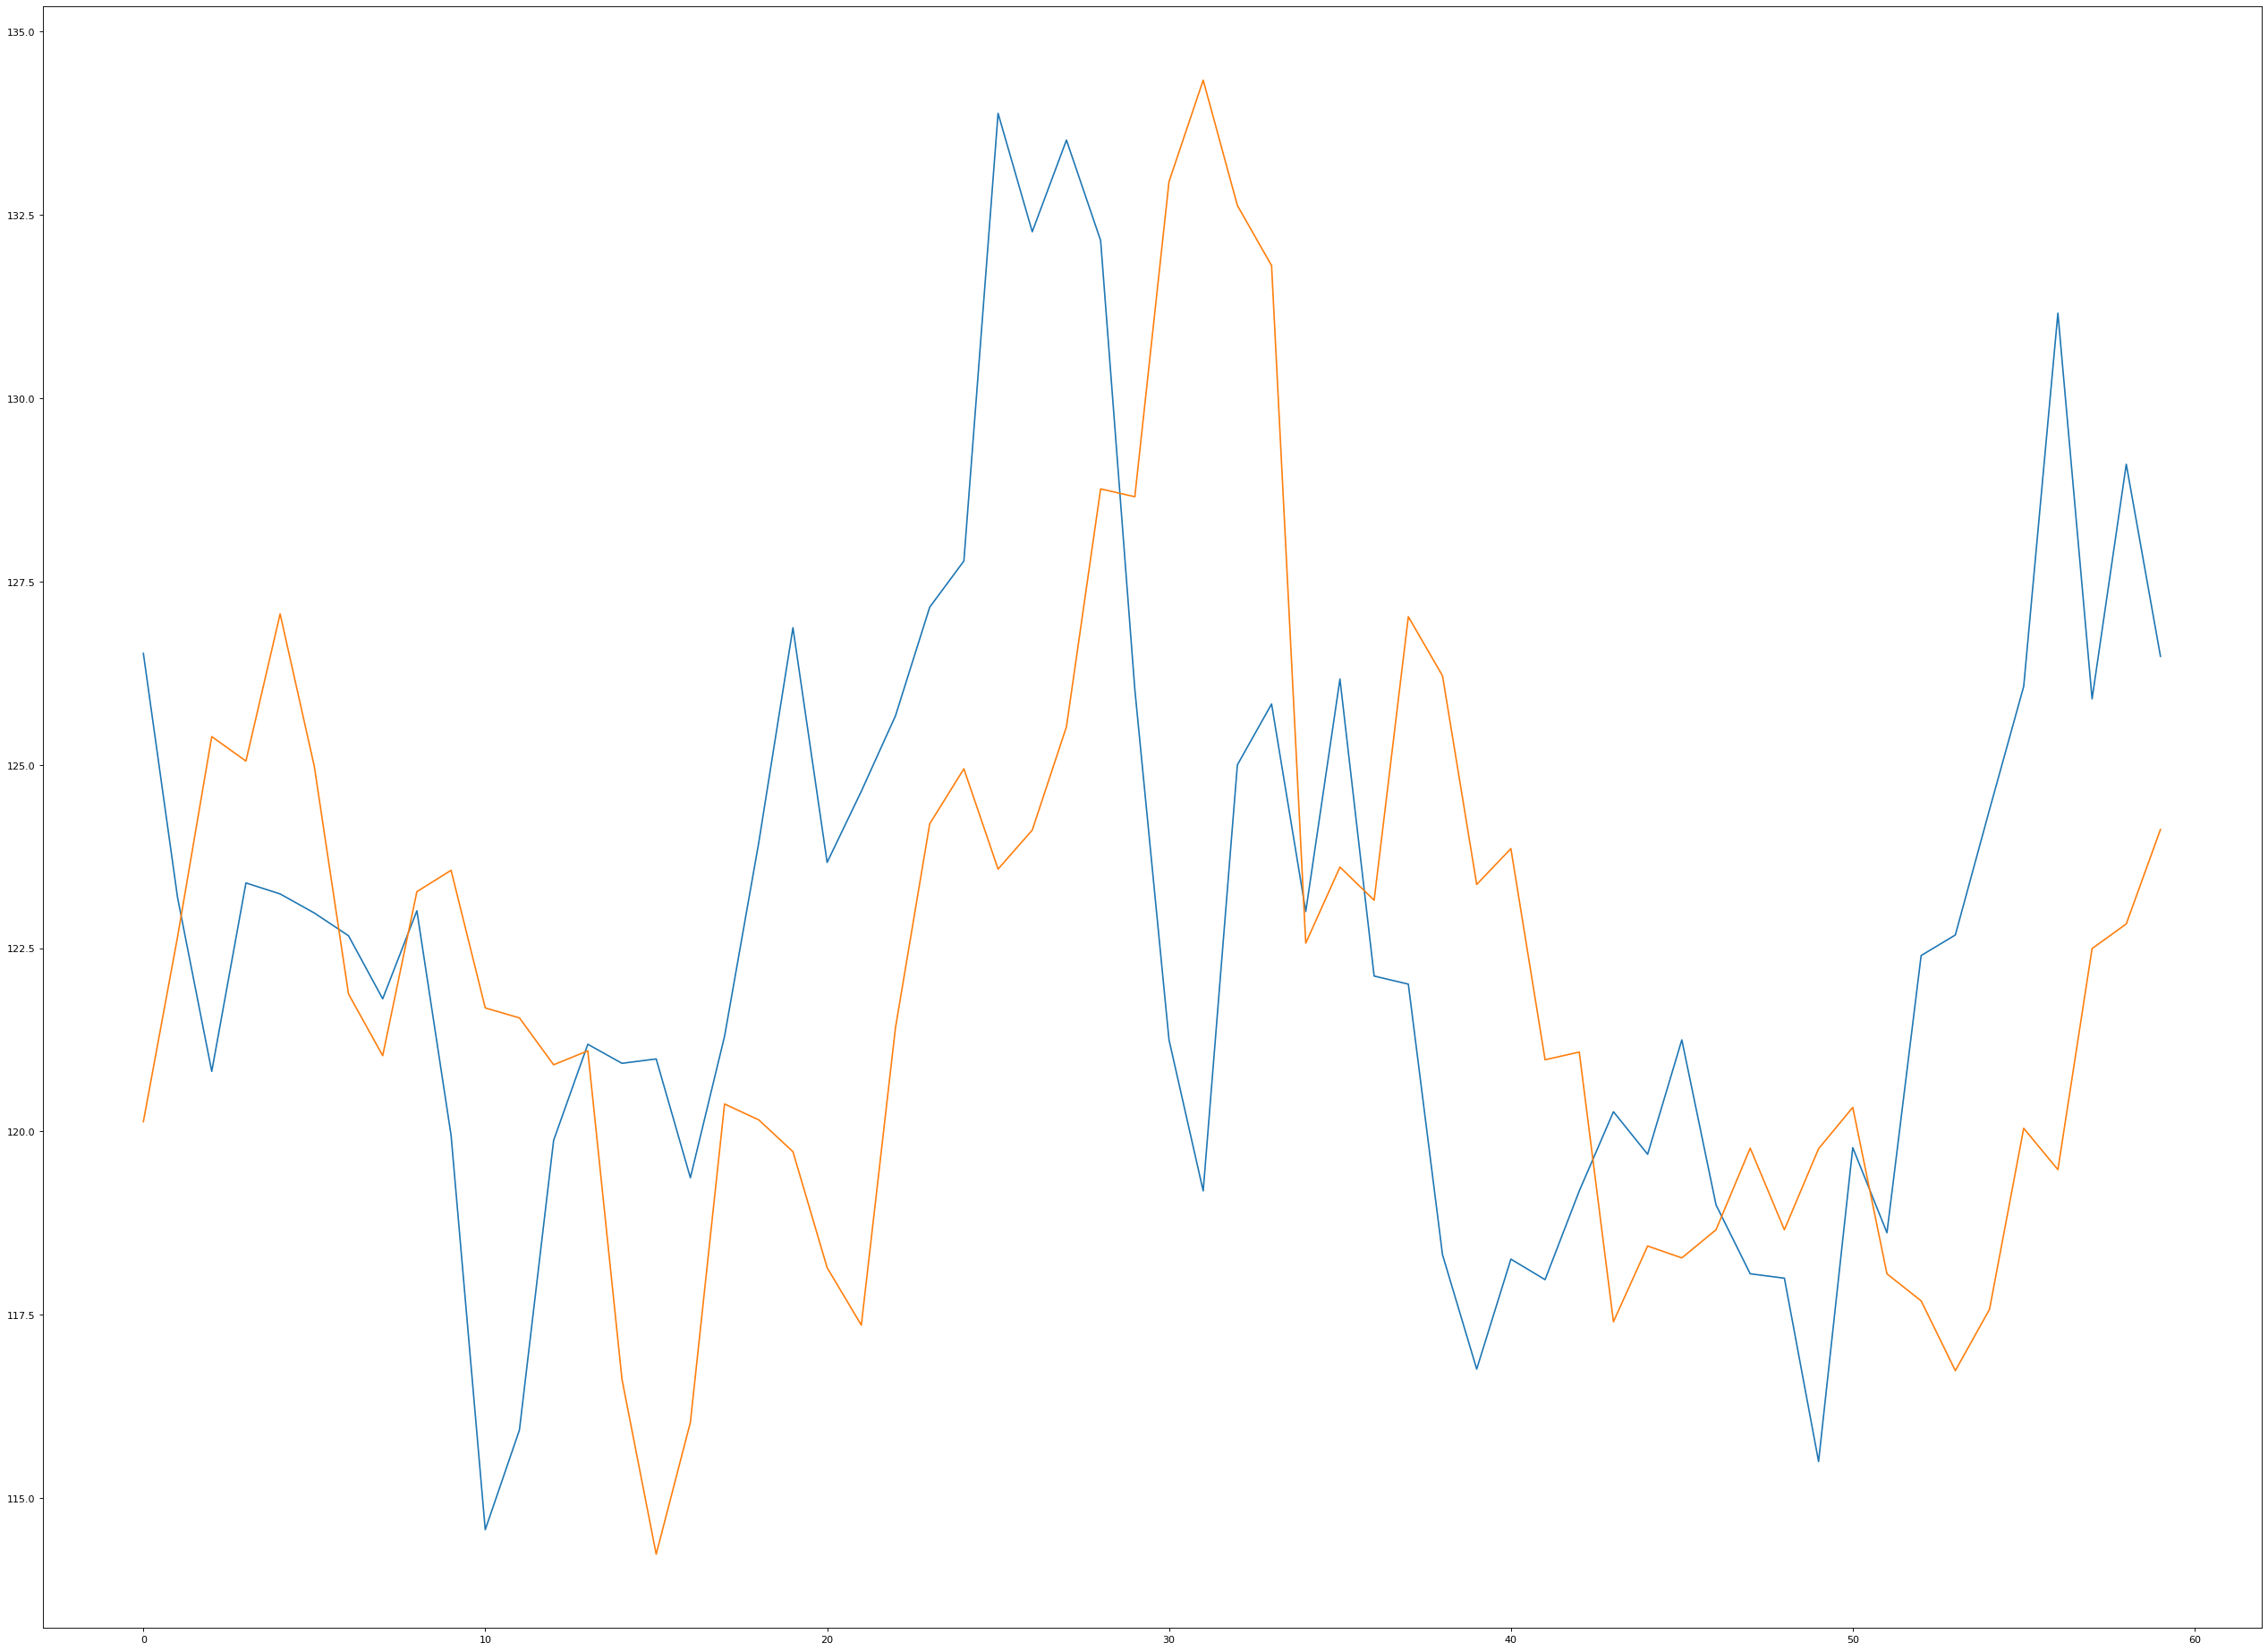

In [43]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(60), true_y_test)
plt.plot(range(60), predicted_y_test)
plt.show()

##### Last 20 days + prediction of last 10 days

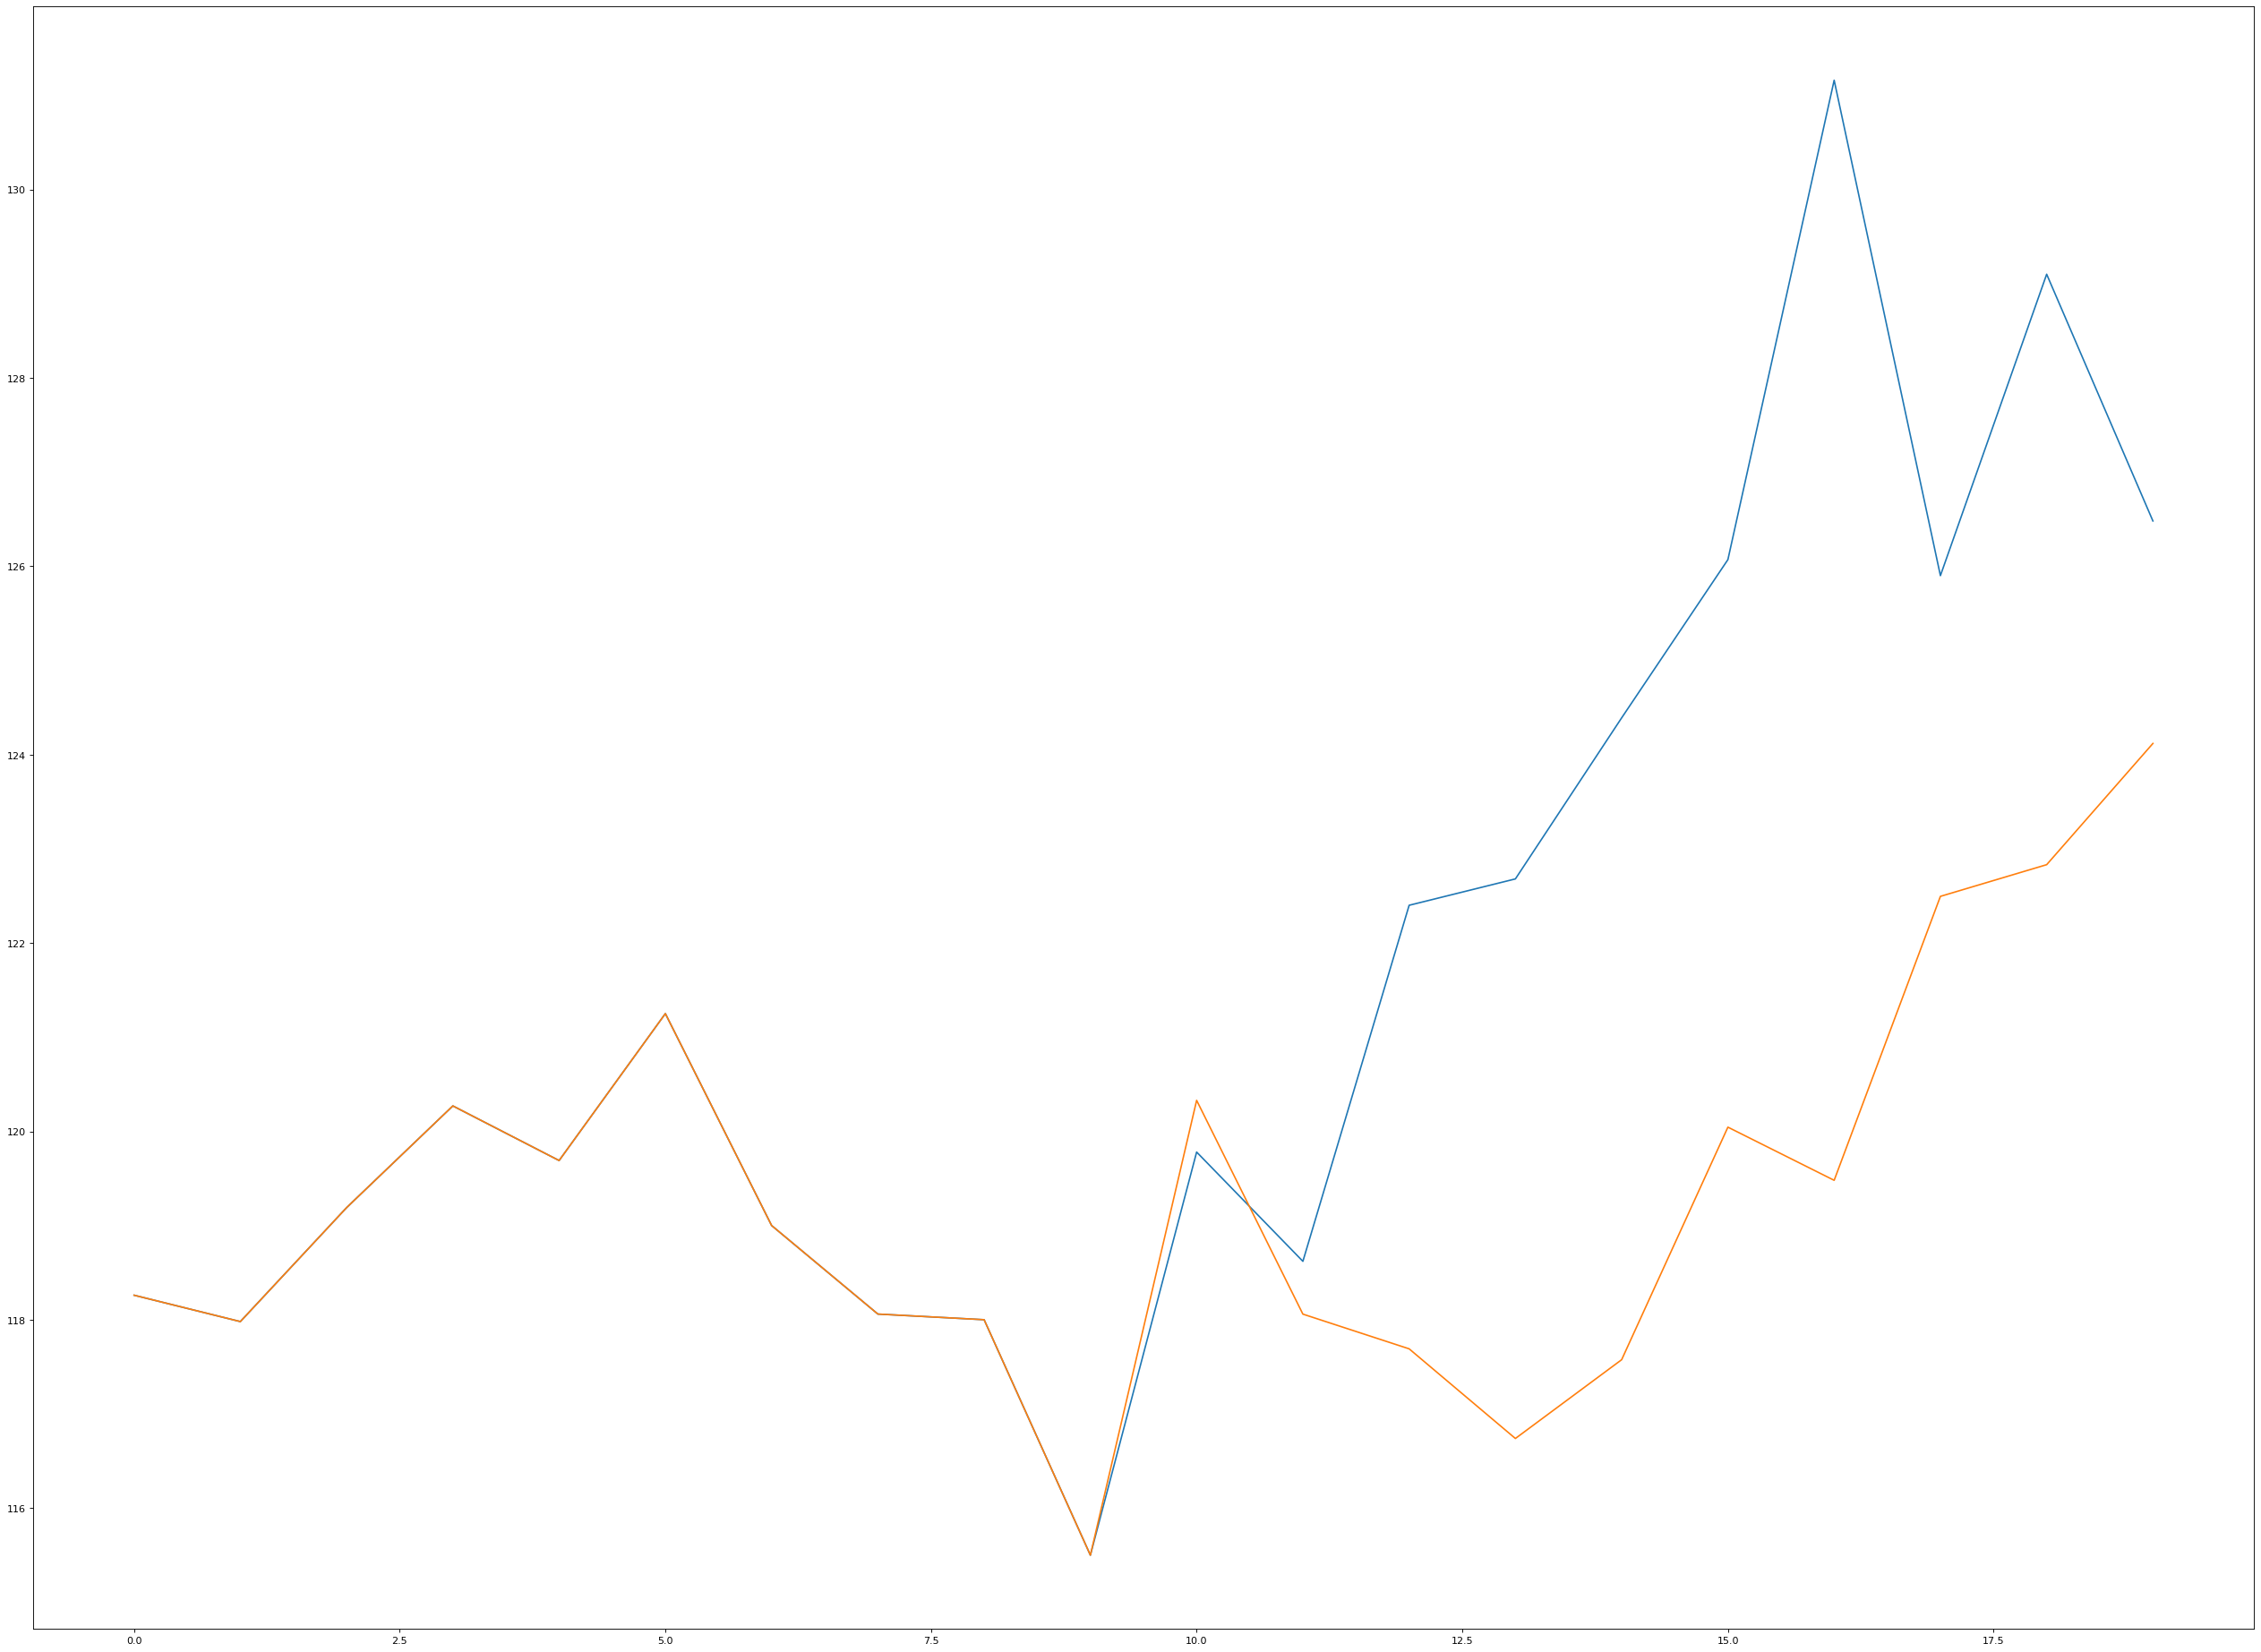

In [44]:
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(20), true_y_test[-20:])
plt.plot(range(20), np.append(true_y_test[-20:-10], predicted_y_test[-10:]))
plt.show()